# Predicting Car Crashes with Time Series Forecasting

Greg Trunz

In this analysis, we will be predicting the number of daily car crashes in the City and County of Denver, Colorado. The number of car crashes in a given geographic region is relevant to various sectors and industries, such as transportation, emergency and healthcare services, as well as towing and automobile repair. We will explore two time-series forecasting frameworks, namely the classical seasonal autoregressive integrated moving average with exogenous variables (SARIMAX) approach, as implemented in the `statsmodels` library,<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) as well as the Prophet forecasting method using the `prophet` library from Facebook.<a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2) 

We begin with an exploratory analysis of the endogenous variable &mdash; the number of daily crashes &mdash; as well as its relationship with two exogenous variables &mdash; holidays and snowfall. We then train various SARIMAX and Prophet models that use different combinations of these exogenous variables, including alternative transformations of the snowfall variable. We rely on data from 2013 through 2018 for model training, and the models generate forecasts for 2019 using an expanding window forecasting method with two-week prediction intervals. Models are primarily evaluated based on their root mean squared error (RMSE) scores, which penalize large errors, but mean absolute error (MAE) scores are also incorporated into the analysis for the sake of interpretability.

It should be emphasized that the exogenous snowfall variables used during the 2019 forecast period are based on actual historical snowfall data. A model forecasting future crashes in real-time would not have this luxury, and instead would have to depend upon weather forecasts &mdash; and the additional uncertainty that they bring &mdash; as input. We therefore consider the performance metrics of any models that use the snowfall variables as being overly optimistic, as they implicitly assume perfect snowfall forecasts. Nonetheless, we use this snow data primarily for purposes of experimentation and analysis.

The findings show that the Prophet models' forecasts outperform those of the SARIMAX models, and that for both frameworks, incorporating snowfall and holidays can potentially strengthen model performance. The inclusion of holidays has a bigger impact than the inclusion of snowfall variables, as well as the choice of modeling framework. The best-performing model overall is a Prophet model using both holidays and transformed snowfall variables as exogenous predictors, and its forecast for 2019 achieves an RMSE score of 11.69 and an MAE score of 8.79, meaning that its predictions are off by fewer than nine crashes on average. However, a Prophet model that used only holidays and excluded snowfall acheived very similar results with an RMSE of 11.71 and an MAE of 8.84. Given this, for a real-world application, it might be most practical to use the Prophet model with only holidays as a default model. Although it has slightly less accuracy, the difference is marginal, and probably worth the benefit of not having to rely on potentially unreliable snow forecasts. 

<a name="cite_note-1"></a><font size = "1.5">1. [^](#cite_ref-1) </font></a><font size = "1.5">Seabold, Skipper, and Josef Perktold. 2010. “statsmodels: Econometric and statistical modeling with python.” Proceedings of the 9th Python in Science Conference.
See also: https://www.statsmodels.org/v0.13.5/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html.</font><br> 
<a name="cite_note-2"></a><font size = "1.5">2. [^](#cite_ref-2) </font></a> <font size = "1.5">Taylor SJ, Letham B. 2017. "Forecasting at scale." <i>PeerJ Preprints</i> 5:e3190v2 https://doi.org/10.7287/peerj.preprints.3190v2.
See also: https://facebook.github.io/prophet/.</font><br> 

### Import Libraries

In [1]:
#import libraries
import os
import calendar
from collections import Counter, OrderedDict, defaultdict
import holidays
import re
import itertools
import logging
import warnings

import pandas as pd
import geopandas as gpd
from shapely import geometry
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels as sm
import statsmodels.api as sm_api
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.oneway import anova_oneway
from statsmodels.tools.sm_exceptions import ConvergenceWarning

import prophet
from prophet import Prophet
from prophet.plot import plot_cross_validation_metric, plot_forecast_component
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.utilities import regressor_coefficients

### Helper Functions

Next, we define a few helper functions that will be utilized elsewhere throughout the analysis.

In [2]:
#function for creating Point variables for a dataframe given long/let variables
def make_point_var(df, point_varname, long_varname, lat_varname):
    df[point_varname] = df.apply(lambda x: geometry.Point(x[long_varname],x[lat_varname]), axis = 1)
    return df

#function for reading in crash data
def read_in_crash_data(year_range):
    #specify columns to use
    usecols = ['DATE','CITY','COUNTY','LATITUDE','LONGITUDE']
    #dict for storing df for each year
    df_dict = OrderedDict()
    for yr in range(year_range[0], year_range[1]+1):
        #read in csv of crashes for given year in range
        df = pd.read_csv(f'data/crash_data/annual_files/{yr}.csv',usecols = usecols)
        #convert string vars to lower
        str_vars = ['CITY','COUNTY']
        for i in str_vars:
            df[i] = df[i].str.lower()
        #subset denver county only
        df = df[df['COUNTY']=='denver'].reset_index(drop = True)
        #make date variable datetime obj
        df['DATE'] = pd.to_datetime(df['DATE'])
        #convert lat/long into point var
        df = make_point_var(df, 
                            point_varname = 'geo_point', 
                            long_varname = 'LONGITUDE', 
                            lat_varname = 'LATITUDE')
        #add file year as variable
        df['file'] = yr
        #add year variable based on crash date
        df['year'] = df['DATE'].dt.year
        #store df in df_dict
        df_dict[yr] = df
    #return df_dict
    return df_dict

#function for reading in weather data
def read_in_weather_data(year_range):
    #dict for storing dictionaries
    stn_data_dict = {}
    #file path where weather data is stored
    stn_data_dir_path = os.path.join('data','weather_data','stn_data')
    #iterate through files in path
    for file in os.listdir(stn_data_dir_path):
        #get station id from filename
        stn_id = file.strip('.csv')
        #read in station df
        df = pd.read_csv('/'.join([stn_data_dir_path,file]))
        #subset years in range
        df['yr'] = pd.to_datetime(df['date']).dt.year
        df = df[df['yr'].between(year_range[0],year_range[1], inclusive = 'both')]
        #store station id in variable
        df['stn_id'] = stn_id
        #indicate whether there is missing snow data for each row
        df['snow_missing'] = df['snow']=='M'
        #store df in dict
        stn_data_dict[stn_id] = df
    #return station data
    return stn_data_dict

#function for determining which geographic area polygon contains a given point
def point_in_area(pt, area_series, get = 'first'):
    assert get in {'first','all'}, "get must have value 'first' or 'all'"
    #make list of all areas containing the point
    containing_areas = area_series[area_series.contains(pt)].to_list()
    #if get=='first', return the first area from list
    if get=='first':
        if len(containing_areas)>=1:
            return containing_areas[0]
        else:
            return 'NONE'
    #if get=='all', return full list
    elif get=='all':
        return containing_areas
    
#make wide version of data
def make_weather_wide(weather_data):
    weather_df_wide = pd.DataFrame({})
    stn_ids = weather_data['stn_id'].unique()
    for i,stn_id in enumerate(stn_ids):
        if i==0:
            keepcols = ['date','snow']
        else:
            keepcols = ['snow']
        df = weather_data[weather_data['stn_id']==stn_id][keepcols]\
                             .reset_index(drop = True)\
                             .rename(columns = {'snow':f'snow_{stn_id}'}).copy()
        weather_df_wide = pd.concat((weather_df_wide,df), axis = 1)
    return weather_df_wide

#function to convert missing and trace weather data to NaN
def weather_mt_to_nan(weather_data):
    wnan = weather_data.replace(to_replace = {'M','T'}, value = np.nan).copy()
    for i in wnan.columns:
        if not i=='date':
            wnan[i] = wnan[i].astype(float)
    return wnan

#function to make snow variables
def make_snow_vars(weather_data):
    df = weather_data.copy()
    df['snow_binary'] = ((df['snow_052223']>0) | (df['snow_052220']>0)).astype(int)
    df['snow_avg'] = df[['snow_052223','snow_052220']].mean(axis = 1).fillna(0)
    df['snow_avg_2'] = df['snow_avg']**2
    df['log_snow_avg'] = np.log(1+df['snow_avg']) 
    df['log_snow_avg_2'] = df['log_snow_avg']**2
    return df

#function for getting the R^2 from a regression
def get_r2(data, preds, target, lib = 'statsmodels'):
    X = data[preds].copy()
    X1 = sm_api.add_constant(X)
    y = data[[target]].copy()
    if lib == 'scikit':
        lr = LinearRegression(fit_intercept = True)
        return lr.fit(X1,y).score(X1,y)
    elif lib == 'statsmodels':
        lr = sm_api.OLS(y,X1).fit()
        return lr.rsquared

### Read in Data

#### Crash Data

The below cell reads in data on crashes from 2013 to 2019 and does some basic pre-processing using the `read_in_crash_data()` function, including limiting the crashes to those where the `COUNTY` variable indicates that the crash took place in Denver. Each row of the dataset represents a crash, and for each crash we have the data, city, county, latitude, and longitude of the crash, as well as a <a href="https://shapely.readthedocs.io/en/stable/reference/shapely.Point.html">shapely Point</a> value based on the crash's latitude and longitude, the year of the data file from which the crash was pulled, and the year of the crash itself. The original source of the data is the Colorado Department of Transportation.<a name="cite_ref-3"></a>[<sup>[3]</sup>](#cite_note-3) 

<a name="cite_note-3"></a><font size = "1.5">3. [^](#cite_ref-3) </font></a><font size = "1.5">Colorado Department of Transportation. "Crash Data." https://www.codot.gov/safety/traffic-safety/data-analysis/crash-data. (Last accessed 10/01/2023).</font><br> 

In [3]:
#read in all creash data for given year range
year_range = (2013,2019)
df_dict = read_in_crash_data(year_range) 
crash_df = pd.concat([i for i in df_dict.values()], ignore_index = True)
print('Crash Data:')
display(crash_df.head())
print('...')
print('Dimensions:',crash_df.shape)

#check whether all dates between the first and last date in the data have crashes
start,end = crash_df.groupby('DATE').size().index.min(),crash_df.groupby('DATE').size().index.max()
all_dates = pd.date_range(start = start, end = end, freq = 'D')
all_in = (crash_df.groupby('DATE').size().index == all_dates).all()
same_len = len(crash_df.groupby('DATE').size())==len(all_dates)
assert (all_in and same_len), 'there are dates with no crashes'

Crash Data:


,DATE,CITY,COUNTY,LATITUDE,LONGITUDE,geo_point,file,year
0,2013-01-01,denver,denver,39.791095,-105.010002,POINT (-105.010002 39.791095),2013,2013
1,2013-01-01,denver,denver,39.775852,-104.978686,POINT (-104.978686 39.775852),2013,2013
2,2013-01-01,denver,denver,39.740068,-104.987248,POINT (-104.987248 39.740068),2013,2013
3,2013-01-01,denver,denver,39.674898,-104.987580,POINT (-104.98758 39.674898),2013,2013
4,2013-01-01,denver,denver,39.718348,-104.959088,POINT (-104.959088 39.718348),2013,2013


...
Dimensions: (149658, 8)


We will also split the crash data into training and testing sets, based on the year of the crashes. The training set will contain data from 2013-2018. It will be used for the exploratory analysis, and during the modeling phase will be used solely for building the models. The testing set will provide the forecasting period and include all crashes from 2019.

In [4]:
#split crash data into training and testing sets
train_years = {'left':2013,'right':2018}
train_filt = crash_df['year'].between(**train_years, inclusive = 'both')
crash_df_train = crash_df[train_filt].copy()
crash_df_test = crash_df[~train_filt].copy()
print('Train crash data:')
display(crash_df_train.head())
print('...')
print('Dimensions:',crash_df_train.shape)
print()
print('Test crash data:')
display(crash_df_test.head())
print('...')
print('Dimensions:',crash_df_test.shape)

Train crash data:


,DATE,CITY,COUNTY,LATITUDE,LONGITUDE,geo_point,file,year
0,2013-01-01,denver,denver,39.791095,-105.010002,POINT (-105.010002 39.791095),2013,2013
1,2013-01-01,denver,denver,39.775852,-104.978686,POINT (-104.978686 39.775852),2013,2013
2,2013-01-01,denver,denver,39.740068,-104.987248,POINT (-104.987248 39.740068),2013,2013
3,2013-01-01,denver,denver,39.674898,-104.987580,POINT (-104.98758 39.674898),2013,2013
4,2013-01-01,denver,denver,39.718348,-104.959088,POINT (-104.959088 39.718348),2013,2013


...
Dimensions: (127541, 8)

Test crash data:


,DATE,CITY,COUNTY,LATITUDE,LONGITUDE,geo_point,file,year
127541,2019-01-01,denver,denver,39.729087,-104.987412,POINT (-104.987412 39.729087),2019,2019
127542,2019-01-01,denver,denver,39.728828,-105.053227,POINT (-105.053227 39.728828),2019,2019
127543,2019-01-01,denver,denver,39.653423,-104.868666,POINT (-104.868666 39.653423),2019,2019
127544,2019-01-01,denver,denver,39.740130,-104.943379,POINT (-104.943379 39.74013),2019,2019
127545,2019-01-01,denver,denver,39.732280,-105.092549,POINT (-105.092549 39.73228),2019,2019


...
Dimensions: (22117, 8)


#### Geographic Data

The next code cell reads in a shapefile for Denver that will enable us to visualize data geographically. The original source of this data is Denver's Open Data Catalog.<a name="cite_ref-4"></a>[<sup>[4]</sup>](#cite_note-4) 

<a name="cite_note-4"></a><font size = "1.5">4. [^](#cite_ref-4) </font></a><font size = "1.5">City and County of Denver. "Open Data Catalog, Statistical Neighborhoods." https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-statistical-neighborhoods. (Last accessed 10/01/2023).</font><br> 

In [5]:
#read in shapefile for denver county
county_gdf = gpd.read_file('data/geo_data/statistical_neighborhoods.shp')
print('Denver County Shapefile:')
display(county_gdf.head())
print('...')
print('Dimensions:',county_gdf.shape)

Denver County Shapefile:


,NBHD_ID,NBHD_NAME,TYPOLOGY,NOTES,geometry
0,56,Sloan Lake,NaN,NaN,"POLYGON ((-105.02523 39.75848, -105.02524 39.7..."
1,39,Jefferson Park,NaN,NaN,"POLYGON ((-105.00949 39.75393, -105.00976 39.7..."
2,14,City Park,NaN,NaN,"POLYGON ((-104.94062 39.75104, -104.94063 39.7..."
3,42,Lowry Field,NaN,NaN,"POLYGON ((-104.88470 39.73285, -104.88471 39.7..."
4,27,Fort Logan,NaN,NaN,"POLYGON ((-105.03462 39.65328, -105.03463 39.6..."


...
Dimensions: (78, 5)


#### Weather Data

Here we read in the weather data and perform some basic pre-processing using the `read_in_weather_data()` function, then concatenate each weather station's data together into a single data frame, which includes daily maximum and minimum temperatures, and snow (in inches), a year variable, the weather station id, and a boolean variable indicating whether the snow measurement is missing. An "M" value for `snow` indicates the snow value is missing. The original source of this data is Colorado State University's Colorado Climate Center.<a name="cite_ref-5"></a>[<sup>[5]</sup>](#cite_note-5) 

<a name="cite_note-5"></a><font size = "1.5">5. [^](#cite_ref-5) </font></a><font size = "1.5">Colorado State University, Colorado Climate Center. "Data Access." https://climate.colostate.edu/data_access_new.html. (Last accessed 10/01/2023).</font><br> 

In [6]:
#read in weather data from each station

#specify year range
year_range = (2013,2019)
#store weather data for each station in a dictionary
stn_data_dict = read_in_weather_data(year_range)
#concatenate station dfs together into a single df
weather_df = pd.concat([stn_data_dict[i] for i in stn_data_dict]).reset_index(drop = True)
print('Weather Data:')
display(weather_df.head())
print('...')
print('Dimensions:',weather_df.shape)

Weather Data:


,date,max_temp,min_temp,snow,yr,stn_id,snow_missing
0,1/1/13,M,M,M,2013,052225,True
1,1/2/13,M,M,M,2013,052225,True
2,1/3/13,M,M,M,2013,052225,True
3,1/4/13,M,M,M,2013,052225,True
4,1/5/13,M,M,M,2013,052225,True


...
Dimensions: (17892, 7)


Similar to the crash data, we will split the weather data into training and testing sets.

In [7]:
#split weather data into training and testing sets
weather_train_filt = pd.to_datetime(weather_df['date']).dt.year <= 2018
weather_df_train = weather_df[weather_train_filt].copy()
weather_df_test = weather_df[~weather_train_filt].copy()
print('Train weather data:')
display(weather_df_train.head())
print('...')
print('Dimensions:',weather_df_train.shape)
print()
print('Test weather data:')
display(weather_df_test.head())
print('...')
print('Dimensions:',weather_df_test.shape)

Train weather data:


,date,max_temp,min_temp,snow,yr,stn_id,snow_missing
0,1/1/13,M,M,M,2013,052225,True
1,1/2/13,M,M,M,2013,052225,True
2,1/3/13,M,M,M,2013,052225,True
3,1/4/13,M,M,M,2013,052225,True
4,1/5/13,M,M,M,2013,052225,True


...
Dimensions: (15337, 7)

Test weather data:


,date,max_temp,min_temp,snow,yr,stn_id,snow_missing
2191,1/1/19,M,M,M,2019,052225,True
2192,1/2/19,M,M,M,2019,052225,True
2193,1/3/19,M,M,M,2019,052225,True
2194,1/4/19,M,M,M,2019,052225,True
2195,1/5/19,M,M,M,2019,052225,True


...
Dimensions: (2555, 7)


We will also read in a data set containing the metadata for each of the weather stations. This information was also pulled from the Colorado Climate Center.<a name="cite_ref-6"></a>[<sup>[6]</sup>](#cite_note-6)

<a name="cite_note-6"></a><font size = "1.5">6. [^](#cite_ref-6) </font></a><font size = "1.5">Ibid.</font><br> 

In [8]:
#read in weather station metadata
stn_meta_df = pd.read_csv('data/weather_data/stn_metadata.csv', dtype = {'id':str})
stn_meta_df = make_point_var(stn_meta_df, point_varname = 'geo_point', long_varname = 'long', lat_varname = 'lat')
print('Weather Station Metadata:')
display(stn_meta_df)
print('Dimensions:',stn_meta_df.shape)

Weather Station Metadata:


,id,name,long,lat,elev_ft,geo_point
0,052211,denver intl ap,-104.65623,39.84657,5404,POINT (-104.65623 39.84657)
1,052213,denver 1 sw 7news,-104.98500,39.72630,5249,POINT (-104.985 39.7263)
2,052215,denver metro state college,-105.00000,39.73333,5242,POINT (-105 39.73333)
3,052220,denver central park,-104.86948,39.76746,5284,POINT (-104.86948 39.76746)
4,052223,denver water dept,-105.00861,39.72944,5225,POINT (-105.00861 39.72944)
5,052225,denver wso city,-104.98333,39.75000,5325,POINT (-104.98333 39.75)
6,052228,denver museum,-104.94250,39.74890,5307,POINT (-104.9425 39.7489)


Dimensions: (7, 6)


The final data component that we need to import is the holidays. These are pulled from the <a href="https://pypi.org/project/holidays/">holidays</a> library and stored in `holidays_df`, which is also split into training and testing sets.

In [9]:
#get holidays data
holidays_dict = OrderedDict(holidays.US(years = range(crash_df['year'].min(), crash_df['year'].max()+1)))
holidays_df = pd.DataFrame({'ds': holidays_dict.keys(), 'holiday': holidays_dict.values()})\
                .sort_values('ds', ignore_index = True)
holidays_df['ds'] = pd.to_datetime(holidays_df['ds'])
print('Holiday Data:')
display(holidays_df.head())
print('...')
print('Dimensions:',holidays_df.shape)

Holiday Data:


,ds,holiday
0,2013-01-01,New Year's Day
1,2013-01-21,Martin Luther King Jr. Day
2,2013-02-18,Washington's Birthday
3,2013-05-27,Memorial Day
4,2013-07-04,Independence Day


...
Dimensions: (75, 2)


In [10]:
#holiday train-test split
holiday_train_filt = pd.to_datetime(holidays_df['ds']).dt.year <= 2018
holidays_df_train = holidays_df[holiday_train_filt].copy()
holidays_df_test = holidays_df[~holiday_train_filt].copy()

print('Train holiday data:')
display(holidays_df_train.head())
print('...')
print('Dimensions:',holidays_df_train.shape)
print()
print('Test holiday data:')
display(holidays_df_test.head())
print('...')
print('Dimensions:',holidays_df_test.shape)

Train holiday data:


,ds,holiday
0,2013-01-01,New Year's Day
1,2013-01-21,Martin Luther King Jr. Day
2,2013-02-18,Washington's Birthday
3,2013-05-27,Memorial Day
4,2013-07-04,Independence Day


...
Dimensions: (65, 2)

Test holiday data:


,ds,holiday
65,2019-01-01,New Year's Day
66,2019-01-21,Martin Luther King Jr. Day
67,2019-02-18,Washington's Birthday
68,2019-05-27,Memorial Day
69,2019-07-04,Independence Day


...
Dimensions: (10, 2)


### Exploratory Data Analysis

We will begin exploring the data by looking at the distribution of the endogenous variable that we will try to forecast, the number of crashes, during the 2013-2018 training period. The below charts show that the number of daily crashes follow a roughly bell-shaped distribution with a thick left tail and a long, thin right tail. It is centered just below 60 crashes per-day, with a minimum of 4 and a maximum of 138.

The shape of the distributions are similar for each year, although they generally shift to the right over time, implying an increasing long-term trend. 

The raw daily time series appears noisy, but we can utilize various visualization techniques to discern meaningful patterns from this.

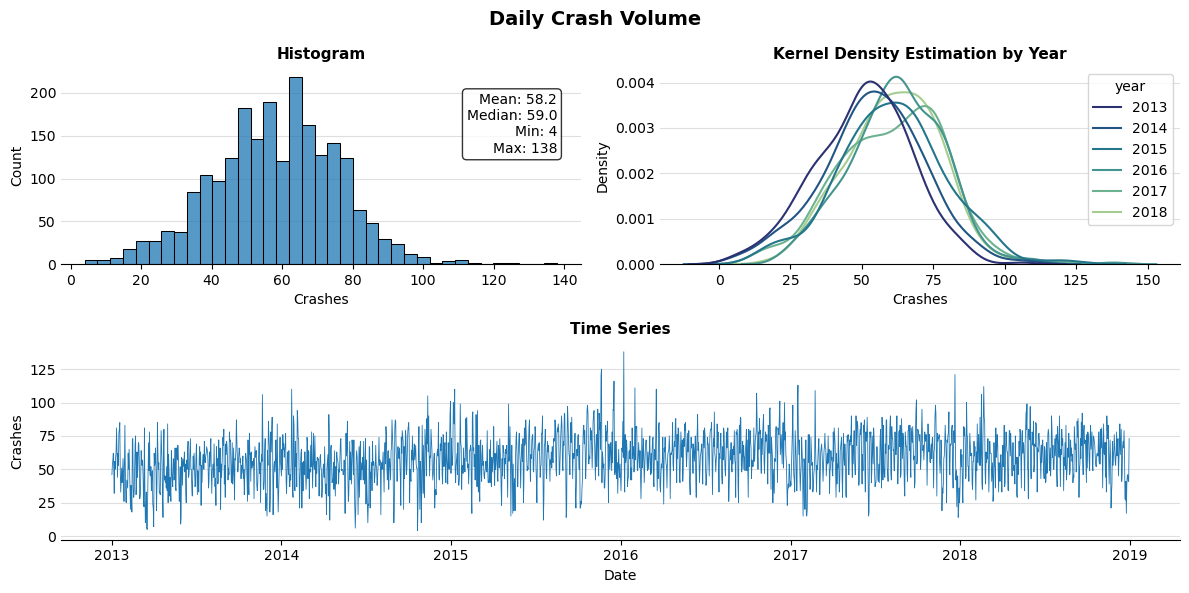

In [11]:
#get crashes for each day included in the data
daily_crashes = crash_df_train.groupby('DATE').size()

#plots of crash data
fig = plt.figure(figsize = (12,6))
gs = fig.add_gridspec(2,2)

#histogram
ax1 = fig.add_subplot(gs[0,0])
sns.histplot(daily_crashes, ax = ax1)
mu = round(daily_crashes.mean(),1)
med = daily_crashes.median()
mn = daily_crashes.min()
mx = daily_crashes.max()
txtbox = dict(boxstyle = 'round', facecolor = 'white', alpha = 0.8)
ax1.text(x = mx, y = 200, s = f'Mean: {mu}\nMedian: {med}\nMin: {mn}\nMax: {mx}', 
         ha = 'right', va = 'top', bbox = txtbox)
ax1.set_title('Histogram', weight = 'bold', size = 11)
ax1.set_xlabel('Crashes')

#kde by year
ax2 = fig.add_subplot(gs[0,1])
plot_df = pd.DataFrame({'crashes':daily_crashes.to_list(),
                        'year':pd.Series(pd.to_datetime(daily_crashes.index).year)})
sns.kdeplot(x = 'crashes', hue = 'year', palette = 'crest_r', data = plot_df)
ax2.set_xlabel('Crashes')
ax2.set_title('Kernel Density Estimation by Year', weight = 'bold', size = 11)

#time series
ax3 = fig.add_subplot(gs[1,:])
sns.lineplot(daily_crashes, linewidth = 0.6, ax = ax3)
ax3.set_ylabel('Crashes')
ax3.set_title('Time Series', weight = 'bold', size = 11)
ax3.set_xlabel('Date')

#common axis formatting
rmv_spines = ['top','right','left']
for ax in [ax1,ax2,ax3]:
    ax.set_axisbelow(True)
    ax.grid(axis = 'y', alpha = 0.4)
    ax.tick_params(axis = 'y', length = 0)
    for s in rmv_spines:
        ax.spines[s].set_visible(False)
        
#figure title
fig.suptitle('Daily Crash Volume', weight = 'bold', size = 14)
fig.tight_layout()

In the next charts we can see a strong weekly pattern. Sundays tend to have the fewest crashes. Then, there is a clear increase in crashes on Monday, and crashes steadily rise from Monday-Friday before declining markedly on Saturday.

There also seems to be some seasonality throughout the year, with more crashes around September and fewer crashes around March, for example, but the differences across months do not seem as pronounced as the differences throughtout the week.

Looking at the number of daily crashes across the years, we see that there is indeed a long-term upward trend, although the increase takes place during the 2013-2016 period and then levels off, even declining somewhat. 

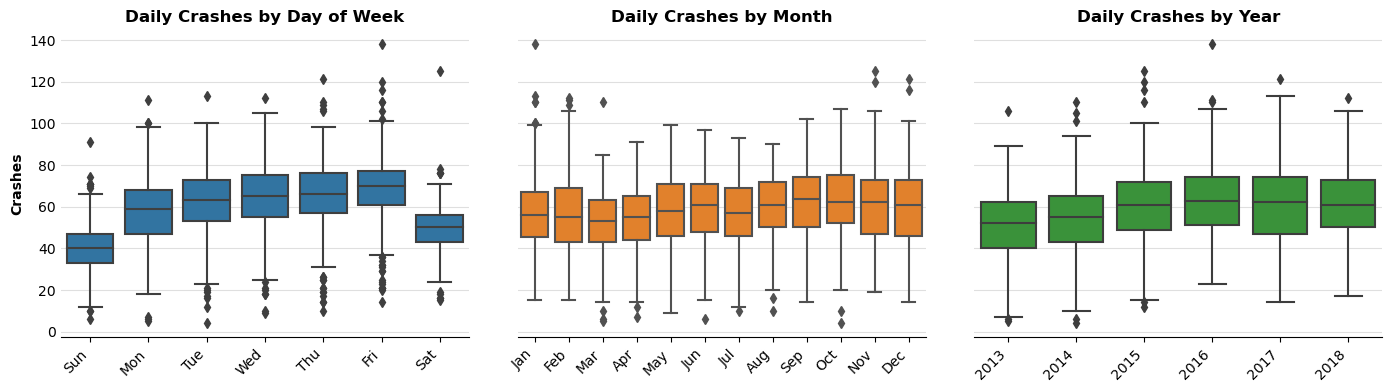

In [12]:
#day-of-week, monthly, annual distributions
plot_df = pd.DataFrame({'date':daily_crashes.index.to_list(),
                        'crashes':daily_crashes.to_list()})
plot_df['dow_name'] = plot_df['date'].dt.day_name() 
plot_df['month'] = plot_df['date'].dt.month_name()
plot_df['year'] = plot_df['date'].dt.year 

#plot
fig, axes = plt.subplots(1,3, figsize = (14,4), sharey = True)
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
sns.boxplot(x = 'dow_name', y = 'crashes', data = plot_df, order = day_order, color = 'C0', ax = axes[0])
sns.boxplot(x = 'month', y = 'crashes', data = plot_df, color = 'C1', ax = axes[1])
sns.boxplot(x = 'year', y = 'crashes', data = plot_df, color = 'C2', ax = axes[2])
#common axis formatting
rmv_spines = ['top','right','left']
titles = ['Daily Crashes by Day of Week','Daily Crashes by Month','Daily Crashes by Year']
for i,(t,ax) in enumerate(zip(titles,axes)):
    ax.set_ylabel('')
    if i==0:
        ax.set_ylabel('Crashes', weight = 'bold')
    ax.tick_params(axis = 'y', length = 0)
    ax.set_title(t, weight = 'bold')
    ax.set_xlabel('')
    ax.set_axisbelow(True)
    ax.grid(axis = 'y', alpha = 0.4)
    for s in rmv_spines:
        ax.spines[s].set_visible(False)
    if i in {0,1}:
        ax.set_xticks(ax.get_xticks(), [i.get_text()[:3] for i in ax.get_xticklabels()], rotation = 45, ha = 'right')
    else:
        ax.set_xticks(ax.get_xticks(), [i.get_text() for i in ax.get_xticklabels()], rotation = 45, ha = 'right')
plt.subplots_adjust(wspace = 300)
fig.tight_layout(pad = 1)

Using insights derived from the above, we can implement a time-series decomposition on the crash data, which will break down the daily crashes into seasonal, trend, and noise components. Here, we will zoom in on a single year, 2018, so that the data is easier to digest visually. This decomposition assumes a seven-day cycle, given the strong weekly component observed in the above visualization. Here we can clearly see the weekly cycles throughout the year. The trend line also reveals fluctuations beyond this weekly cycle, several of which appear to correspond to holidays, which we will examine more closely soon.

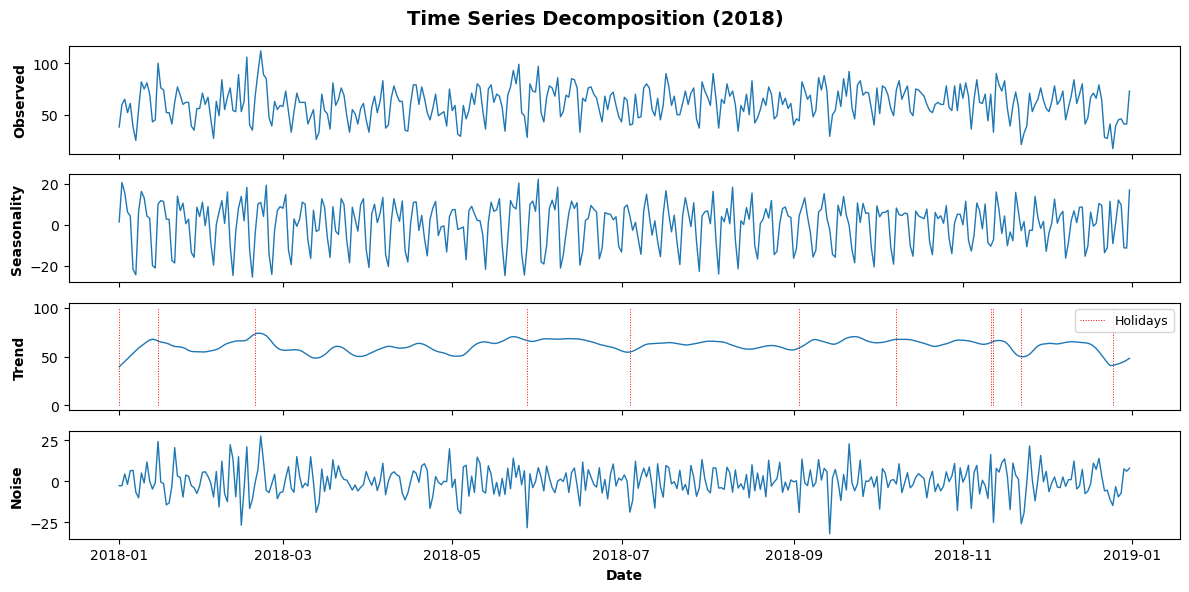

In [13]:
#time series decomposition for a given year (2018)
decomposition = STL(daily_crashes.loc['01-01-2018':'12-31-2018'], period = 7).fit()

components = {'observed'   : decomposition.observed,
              'seasonality': decomposition.seasonal,
              'trend'      : decomposition.trend,
              'noise'      : decomposition.resid}

#make holidays df and add holidays
holidays_2018 = holidays_df_train[pd.to_datetime(holidays_df_train['ds']).dt.year == 2018].copy()
holiday_2018_dates = daily_crashes.index.to_numpy()[pd.Series(daily_crashes.index).isin(holidays_2018['ds'])]

#plot
fig,axes = plt.subplots(4,1,figsize = (12,6), sharex = True)
for ax,(c,d) in zip(axes,components.items()): 
    sns.lineplot(d, linewidth = 1, ax = ax)
    if c=='trend':
        ax.vlines(x = holiday_2018_dates, ymin = 0, ymax = 100, label = 'Holidays',
                  color = 'red', linestyle = ':', linewidth = 0.7)
        ax.legend(fontsize = 9)
    ax.set_ylabel(c.title(), weight = 'bold')

axes[3].set_xlabel('Date', weight = 'bold')
fig.suptitle('Time Series Decomposition (2018)', weight = 'bold', size = 14)
fig.tight_layout()

An Augmented Dickey-Fuller (ADF) test<a name="cite_ref-7"></a>[<sup>[7]</sup>](#cite_note-7)  of the daily crashes from 2013-2018 indicates that the pattern is stationary, which suggests we do not need to apply non-seasonal differencing in our SARIMAX model.<a name="cite_ref-8"></a>[<sup>[8]</sup>](#cite_note-8) 


<a name="cite_note-7"></a><font size = "1.5">7. [^](#cite_ref-7) </font></a><font size = "1.5">David A. Dickey & Wayne A. Fuller. 1979. "Distribution of the Estimators for Autoregressive Time Series with a Unit Root," <i>Journal of the American Statistical Association</i>, 74:366a, 427-431, DOI: 10.1080/01621459.1979.10482531.</font><br> 
    
<a name="cite_note-8"></a><font size = "1.5">8. [^](#cite_ref-8) </font></a><font size = "1.5">Peixeiro, Marco. <i>Time Series Forecasting in Python.</i> Manning, 2022.</font><br> 

In [14]:
#Augmented Dickey-Fuller (ADF) test of stationarity
alpha = 0.05
adf_p = adfuller(daily_crashes)[1]
print('p-value:',adf_p)
if adf_p < 0.05:
    print('Assume data is stationary. Do not need to apply non-seasonal differencing.')
else:
    print('Assume data is non-stationary. Apply non-seasonal differencing.')
#raw daily data is not stationary (p>0.05)

p-value: 2.574011743536251e-06
Assume data is stationary. Do not need to apply non-seasonal differencing.


We can also check for autocorrelation in the daily crashes. The below plots show strong autocorrelation at a single day lag, as well as at lags divisible by seven &mdash; reflecting the previously mentioned weekly pattern. 

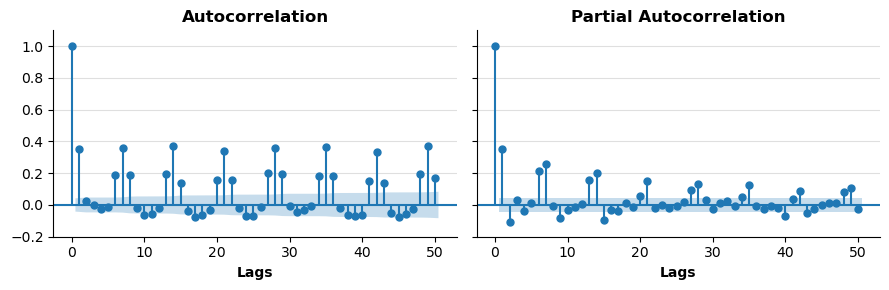

In [15]:
#check for autocorrelation
fig,axes = plt.subplots(1,2,figsize = (9,3), sharey = True, sharex = True)
plot_acf(daily_crashes, lags = 50, ax = axes[0]);
plot_pacf(daily_crashes, method='ywm', lags = 50, ax = axes[1]);

#common axis formatting
rmv_spines = ['top','right']
titles = ['Autocorrelation','Partial Autocorrelation']
for t,ax in zip(titles,axes):
    ax.set_title(t, weight = 'bold')
    ax.set_xlabel('Lags', weight = 'bold')
    ax.set_axisbelow(True)
    ax.grid(axis = 'y', alpha = 0.4)
    ax.set_ylim(-0.2,1.1)
    for s in rmv_spines:
        ax.spines[s].set_visible(False)
fig.tight_layout()

Looking more closely at the holidays, we can see below that several holidays tend to exhibit a very low number of crashes relative to non-holidays, particularly Thanksgiving and Christmas. This suggests that incorporating holidays into the forecasting model may help improve its predictions. 

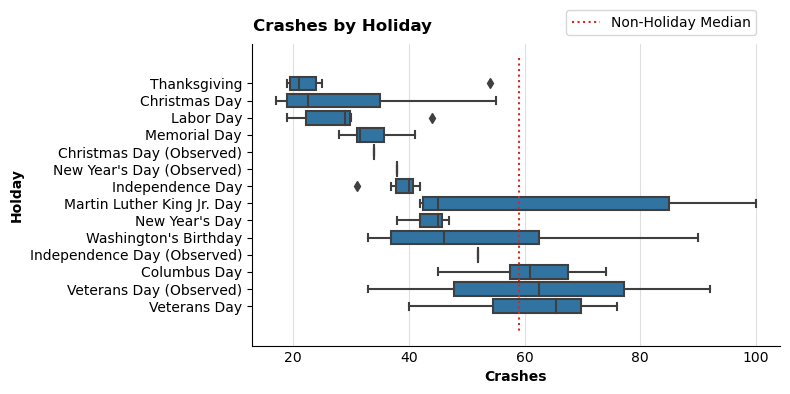

In [16]:
#crash distributions for holidays
#make plot df
plot_df = pd.DataFrame({'ds':pd.to_datetime(daily_crashes.index).tolist(),
                        'crashes':daily_crashes.tolist()})
plot_df = plot_df.merge(holidays_df_train, how = 'left', on = 'ds')
plot_df['holiday'] = plot_df['holiday'].fillna('NONE')
#median among all non-holidays
non_holiday_med =  plot_df[plot_df['holiday']=='NONE']['crashes'].median()
#sort holidays from lowest to highest median crashes
sorted_holidays = plot_df[plot_df['holiday']!='NONE']\
                         .groupby('holiday', as_index = False)\
                         .median(numeric_only = True)\
                         .sort_values('crashes', ignore_index = True)['holiday']
#plot
fig, ax = plt.subplots(1,1,figsize = (8,4))
sns.boxplot(x = 'crashes', y = 'holiday', data = plot_df[plot_df['holiday']!='NONE'], color = 'C0', ax = ax,
           order = sorted_holidays)
ax.vlines(x = non_holiday_med, ymin = -1.5, ymax = len(plot_df[plot_df['holiday']!='NONE']['holiday'].unique())+0.5,
          linestyle = ':', color = 'C3', label = 'Non-Holiday Median')
#format
rmv_spines = ['top','right']
ax.set_axisbelow(True)
ax.grid(axis = 'x', alpha = 0.4)
ax.tick_params(axis = 'x', length = 0)
for s in rmv_spines:
    ax.spines[s].set_visible(False)
ax.set_xlabel('Crashes', weight = 'bold')
ax.set_ylabel('Holday', weight = 'bold')
fig.legend(bbox_to_anchor = (0.96,0.99))
fig.suptitle('Crashes by Holiday', weight = 'bold', x = 0.435, y = 0.95)
fig.tight_layout()

### Examine Geographic Distribution of Crashes

Now we will look at the geographic distribution of crashes. We want to do this because weather stations are situated at different locations throughout the county, and if we see that certain weather stations are in locations with higher crash volumes, their weather data may be of greater relevance than data from weather stations located in areas where not many crashes typically take place. Below we see that there are indeed major geographic differences in crash volumes.

Percentage of crashes with geo coordinates in more than one location: 0.005%
Percentage of crashes with geo coordinates in no location: 3.092%


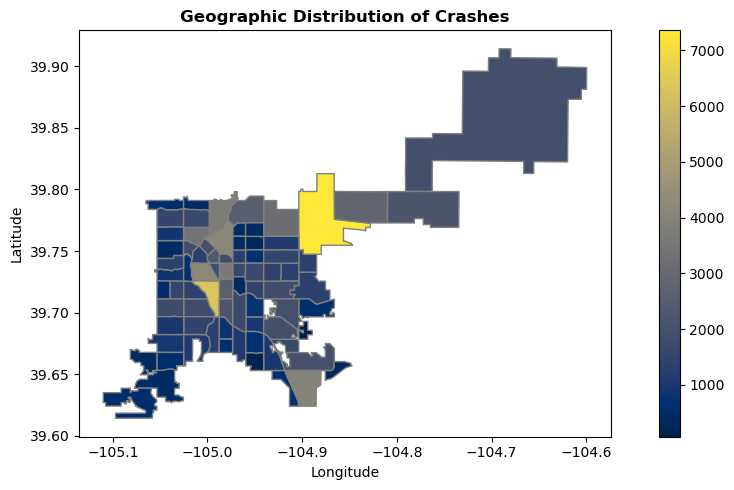

In [17]:
#compute volume of crashes by geographic area

#apply function to create area_poly variable
area_series = county_gdf['geometry']
crash_df_train['area_poly'] = crash_df_train['geo_point'].apply(lambda x: point_in_area(x, 
                                                                                        area_series, 
                                                                                        get = 'first')).copy()
#plot crash volumes by geography
area_crash_counts = crash_df_train.groupby('area_poly', as_index = False, sort = False)\
                                  .size()\
                                  .rename(columns = {'area_poly':'geometry', 'size':'crash_count'})

#check how many crashes have geocoordinates in multiple or no geographic areas of the county
point_area_lists = crash_df_train['geo_point'].apply(lambda x: point_in_area(x, area_series, get = 'all')).copy()
pct_gt_1 = (point_area_lists.apply(lambda x: len(x))>1).mean()*100
pct_eq_0 = (point_area_lists.apply(lambda x: len(x))==0).mean()*100
print(f'Percentage of crashes with geo coordinates in more than one location: {round(pct_gt_1,3)}%')
print(f'Percentage of crashes with geo coordinates in no location: {round(pct_eq_0,3)}%')

#plot geographic distribution of crashes for full time period
crash_counts_gdf = county_gdf.merge(area_crash_counts, how = 'left', on = 'geometry')
fig, ax = plt.subplots(1,1,figsize = (10,5))
crash_counts_gdf.plot(column = 'crash_count', legend = True, cmap = 'cividis', edgecolor = 'gray', ax = ax)
ax.set_title('Geographic Distribution of Crashes', weight = 'bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
fig.tight_layout()

We can generate a visualization like this for each year to ensure this pattern is roughly consistent across the years, and indeed we see that it is.

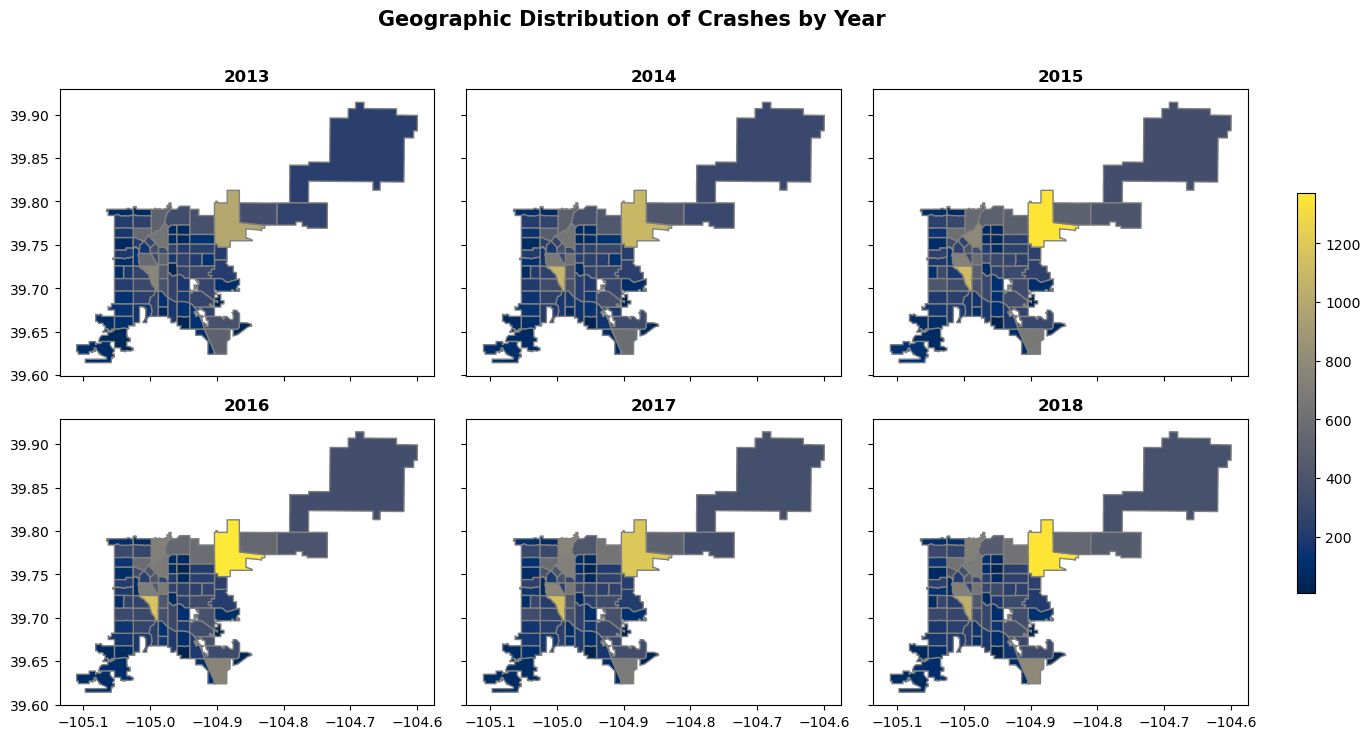

In [18]:
#plot geographic distribution for each year
#annualize data
annual_area_crash_counts = crash_df_train.groupby(['year','area_poly'], as_index = False, sort = False)\
                                         .size()\
                                         .rename(columns = {'area_poly':'geometry'})
#plot
fig, axes = plt.subplots(2,3,figsize = (18,8), sharex = True, sharey = True)
vmin,vmax = annual_area_crash_counts['size'].min(),annual_area_crash_counts['size'].max()
iteraxes = np.array(axes).flatten()
legend_ax = fig.add_axes([0.87, 0.25, 0.01, 0.5])
for i,(yr,ax) in enumerate(zip(sorted(crash_df_train['year'].unique()), iteraxes)):
    yr_crash_counts = annual_area_crash_counts[annual_area_crash_counts['year']==yr].reset_index(drop = True)
    crash_counts_yr_gdf = county_gdf.merge(yr_crash_counts, how = 'left', on = 'geometry')
    crash_counts_yr_gdf.plot(column = 'size', ax = ax, cax = legend_ax,
                                  legend = (i==4), edgecolor = 'gray',
                                  cmap = 'cividis', vmin = vmin, vmax = vmax)
    ax.set_title(yr, weight = 'bold')
fig.suptitle('Geographic Distribution of Crashes by Year', weight = 'bold', size = 15)
plt.subplots_adjust(wspace = -0.3, hspace = 0.15)
plt.show()

### Weather Station Data 

Now we can overlay the weather station locations onto the crash data. Before we do that, however, we will eliminate weather stations where the snow data is missing for 10 percent of the dates or more. The below visualization shows the locations of the weather stations that we will remove from the analysis and those that we will keep.

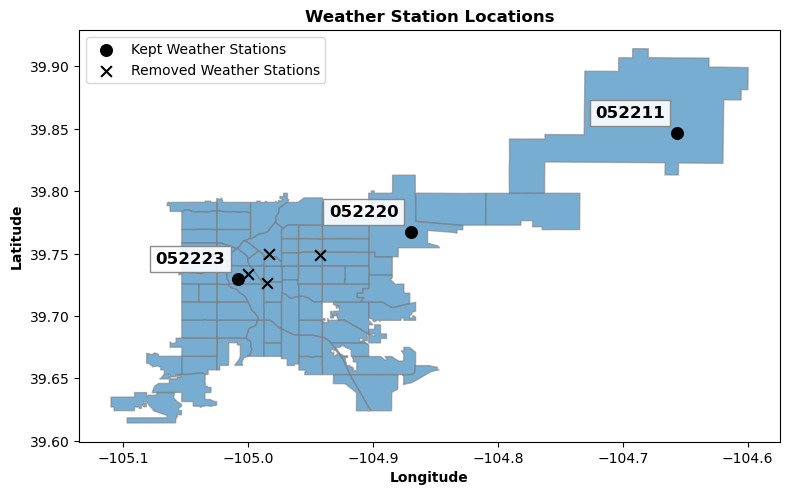

In [19]:
#check how much snow data is missing for each station
missing_weather_data = weather_df_train.groupby('stn_id', as_index = False)\
                                       .mean(numeric_only = True)[['stn_id','snow_missing']]\
                                       .rename(columns = {'stn_id':'id'})
#add share of missing data for snow to station metadata
stn_meta_df = stn_meta_df.merge(missing_weather_data, how = 'right', on = 'id')

#specify threshold
missing_th = 0.1
#use threshold to define filter for keeping stations
keep_filt = (stn_meta_df['snow_missing']<=missing_th)
#define which stations to keep and which to remove
keep_stn = stn_meta_df[keep_filt].copy()
remv_stn = stn_meta_df[~keep_filt].copy()

#plot stations to be kept and those that will be removed based on missing data threshold
fig,ax = plt.subplots(1,1, figsize = (8,5))
#plot map
county_gdf.plot(color = 'C0', edgecolor = 'gray', alpha = 0.6, ax = ax)
#plot kept stations
keep_gdf = gpd.GeoDataFrame(geometry = keep_stn['geo_point'])
keep_gdf.plot(color = 'black', markersize = 70, ax = ax, label = 'Kept Weather Stations')
#plot removed weather stations
remv_gdf = gpd.GeoDataFrame(geometry = remv_stn['geo_point'])
remv_gdf.plot(color = 'black', markersize = 60, marker = 'x', ax = ax, label = 'Removed Weather Stations')
#plot kept station id#s
for i,stn in keep_stn.iterrows():
    txt = ax.text(x = stn['geo_point'].centroid.x - 0.01, 
                  y = stn['geo_point'].centroid.y + 0.01, 
                  s = stn['id'],
                  ha = 'right', va = 'bottom', weight = 'bold', size = 12)
    txt.set_bbox({'facecolor':'white', 'edgecolor':'gray','alpha':0.9})
ax.set_title('Weather Station Locations', weight = 'bold')
ax.legend(loc = 'upper left')
ax.set_xlabel('Longitude', weight = 'bold')
ax.set_ylabel('Latitude', weight = 'bold')
fig.tight_layout()

The below plot shows that two of the stations, 052220 and 052223, are located in or near areas with high crash volumes, while 052211 is situated in an area with relatively few crashes.

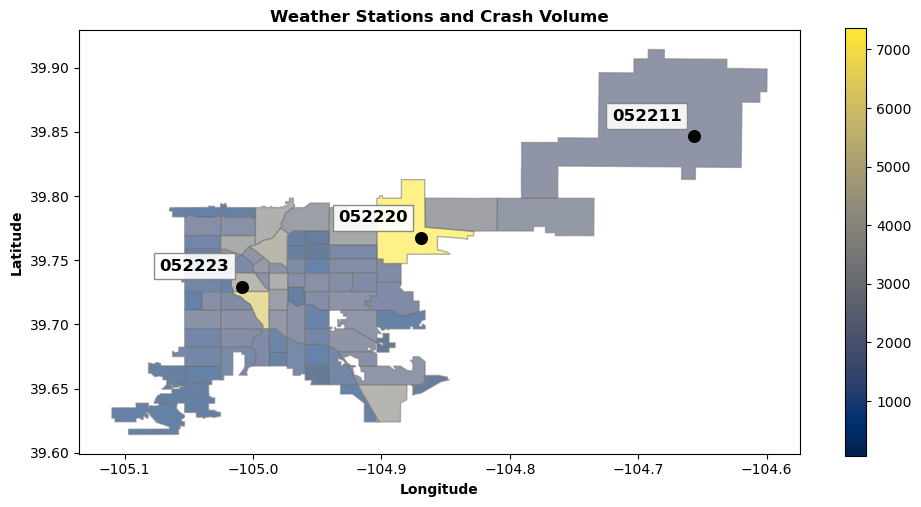

In [20]:
#overlay stations with crash data
fig, ax = plt.subplots(1,1,figsize = (10,5))
crash_counts_gdf.plot(column = 'crash_count', cmap = 'cividis', edgecolor = 'gray', 
                      legend = True, alpha = 0.6, ax = ax)
keep_gdf.plot(color = 'black', markersize = 70, ax = ax, alpha = 1)
#plot kept station id#s
for i,stn in keep_stn.iterrows():
    txt = ax.text(x = stn['geo_point'].centroid.x - 0.01, 
                  y = stn['geo_point'].centroid.y + 0.01, 
                  s = stn['id'],
                  ha = 'right', va = 'bottom', weight = 'bold', size = 12)
    txt.set_bbox({'facecolor':'white', 'edgecolor':'gray','alpha':0.9})
ax.set_title('Weather Stations and Crash Volume', weight = 'bold')
ax.set_xlabel('Longitude', weight = 'bold')
ax.set_ylabel('Latitude', weight = 'bold')
fig.tight_layout()

### Snow Data

Next we will look at the weather data, specifically the snowfall variables. First, we will drop the stations we will not be using, and convert the data to a wide format that will facilitate easier analysis.

In [21]:
#subset weather data for the stations to be kept
keep_filt = weather_df_train['stn_id'].isin(keep_stn['id'])
weather_df_train = weather_df_train[keep_filt].reset_index(drop = True)
weather_df_wide = make_weather_wide(weather_df_train)

The below cell shows the shares of "T" and "M" values for each of the weather stations. "T" value sindicates trace amounts of snow for which a specific measurement is not given, and "M" indicates missing data.

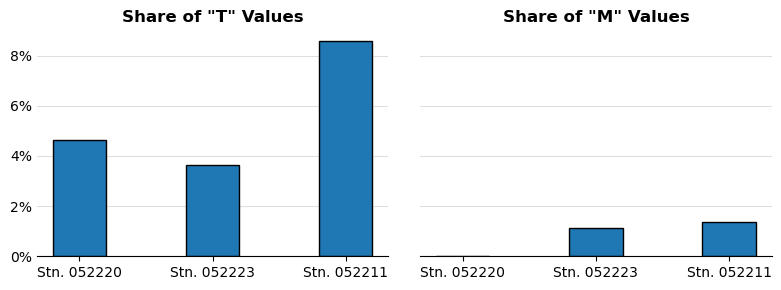

In [22]:
#view magnitude of missing data
num_cols = [i for i in weather_df_wide if i!='date'] 
missing_vals = ['T','M']
stn_lst = [''.join([j for j in i if j.isnumeric()]) for i in weather_df_wide.columns if i!='date']
stn_ids = list(OrderedDict.fromkeys(stn_lst).keys())
fig, axes = plt.subplots(1,2,figsize = (8,3), sharey = True)
bw = 0.4
for i,(ax,mv) in enumerate(zip(axes,missing_vals)):
    snow = [(weather_df_wide[i] == mv).mean() for i in num_cols if 'snow' in i]
    ax.bar(x = np.arange(len(snow)), height = snow, width = bw, color = 'C0', edgecolor = 'black')
    ax.set_xticks(np.arange(len(stn_ids)), [f'Stn. {i}' for i in stn_ids])
    ax.set_title(f'Share of "{mv}" Values', weight = 'bold')
    ax.set_axisbelow(True)
    ax.grid(axis = 'y', alpha = 0.4)
    ax.tick_params(axis = 'y', length = 0)
    rmv_spines = ['top','right','left']
    for s in rmv_spines:
        ax.spines[s].set_visible(False)
    if i==0:
        #ax.legend()
        ax.set_yticks(ax.get_yticks(),[f'{round(i*100)}%' for i in ax.get_yticks()])
fig.tight_layout()

For now we will convert these values to NaN.

In [23]:
#convert missing and trace weather data to NaN
wdf = weather_mt_to_nan(weather_df_wide)

The below pairwise correlation plots show that the snowfall values for stations 052223 and 052220 have a moderately strong positive linear correlation, but the correlation between each of these stations' snowfall data with that of station 052211 appears to be weak.

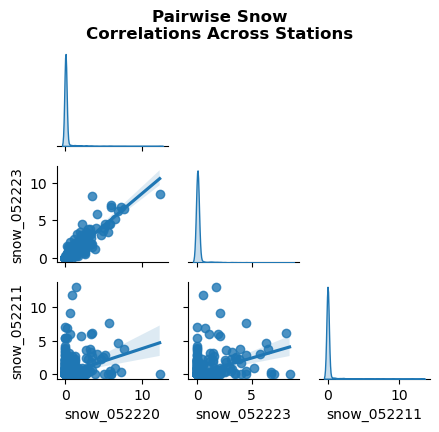

In [24]:
#pairplots
pg = sns.pairplot(data = wdf[[i for i in wdf.columns if 'snow' in i]],
                      kind = 'reg', diag_kind = 'kde', corner = True,
                       height = 1.5, dropna = True)
pg.fig.suptitle(f'Pairwise Snow\nCorrelations Across Stations', weight = 'bold', y = 0.95)
pg.fig.tight_layout()

There are many reasonable ways in which we can represent the snowfall data across the various stations. We will aim to feed only one or two snowfall variables into each model at a time to reduce model complexity, which means we will need to either combine or drop a portion of the data. To keep things simple, we will drop the data from station 052211 given that fewer crashes tend to take place in the surrounding area, and use variables that combine data from stations 052220 and 052223. These will include the following:
 - `snow_binary`: 1 if stations 052223 OR 052220 have a snowfall values greater than zero, else 0.
 - `snow_avg`: The average snowfall values of stations 052223 and 052220, which we know are correlated with each other. This variable will take a value of zero if both stations have values of "T" or "M".
 - `snow_avg_2`: `snow_avg` squared. This will be be used to capture a potential non-linear relationship between `snow_avg` and the daily crash volume &mdash; specifically, a second-order polynomial relationship.
 - `log_snow_avg`: Equal to $ln(1+\text{snow_avg})$. This will be be used to account for the fact that the `snow_avg` variable is highly skewed, and to potentially strengthen its linear relationship with crash volume. 
 - `log_snow_avg_2`: Equal to $ln(1+\text{snow_avg})^2$. This will be be used to capture a potential second-order polynomial relationship between `log_snow_avg` and daily crash volume. 
 
Note that when we are building our time series models later, when we are using second-order polynomial snow predictors, we will be using both the original snow variable and the squared snow variable (e.g., if a model is said to use Log Snow Avg^2, it is using both `log_snow_avg` and `log_snow_avg_2` variables). 
 
The below cell creates these variables using the `make_snow_vars()` custom function and adds the crash data to the dataset to facilitate analysis of the relationship between these snow variables and the crash data.

In [25]:
#make snow variables
wdf = make_snow_vars(wdf)
#add training crash data to the weather data
wdf['crashes'] = daily_crashes.to_list()

To start with the simplest snow variable, we will look at `snow_binary`. The below plot shows that on average there tend to be more crashes when there is snow than when there is not. The mean number of crashes on snow days is 67.2, compared to about 57.4 for no-snow days. However, the plots also show that there is a large degree of variation within and overlap between the distributions, suggesting it would be hard to predict the number of crashes based on this variable alone.

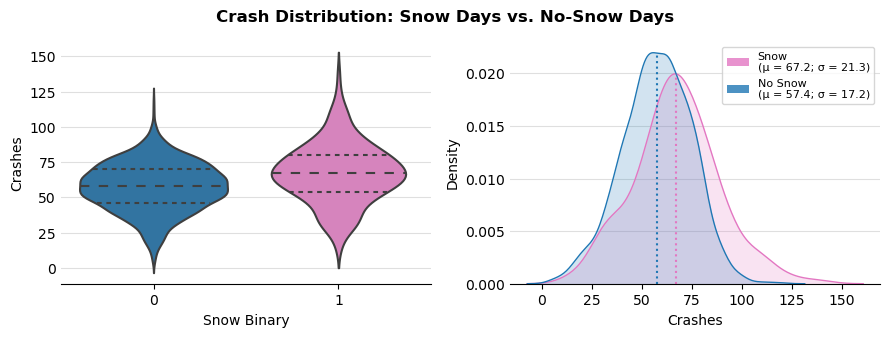

In [26]:
#snow binary
cat_vals = [0,1]
cat_names = ['No Snow','Snow']
colors = ['C0','C6']
fig,axes = plt.subplots(1,2,figsize = (9,3.5))
sns.violinplot(y = 'crashes', x = 'snow_binary', data = wdf, ax = axes[0],
               inner = 'quartile', palette = colors)
kdeplot = sns.kdeplot(x = 'crashes', hue = 'snow_binary', data = wdf, ax = axes[1],
                      common_norm = False, linewidth = 1, legend = None, palette = colors)
sns.kdeplot(x = 'crashes', hue = 'snow_binary', data = wdf, ax = axes[1], common_norm = False, 
            fill = True, alpha = 0.2, linewidth = 0, legend = None, palette = colors)
axes[0].set_xlabel('Snow Binary')
axes[0].set_ylabel('Crashes')
cat_vals.reverse()
cat_names.reverse()
colors.reverse()
for l,cv,cn,c in zip(axes[1].get_lines(),cat_vals,cat_names,colors):
    x = l.get_xdata().copy()
    y = l.get_ydata().copy()    
    mean = wdf[wdf['snow_binary']==cv]['crashes'].mean()
    std = wdf[wdf['snow_binary']==cv]['crashes'].std()
    y_at_mean = np.interp(mean, x, y)
    axes[1].vlines(x = mean, ymin = 0, ymax = y_at_mean, linestyle = ':', color = c)
    axes[1].bar([np.nan],[np.nan], color = c, 
                label = f'{cn}\n(μ = {round(mean,1)}; σ = {round(std,1)})', 
                alpha = 0.8)
axes[1].set_xlabel('Crashes')
axes[1].legend(fontsize = 8)
fig.suptitle('Crash Distribution: Snow Days vs. No-Snow Days', weight = 'bold', y = 0.95)
rmv_spines = ['top','right','left']
for ax in axes:
    ax.set_axisbelow(True)
    ax.grid(axis = 'y', alpha = 0.4)
    ax.tick_params(axis = 'y', length = 0)
    for s in rmv_spines:
        ax.spines[s].set_visible(False)
fig.tight_layout()

Looking at the `snow_avg` variable, we see that its distribution is skewed right, with many zero and near-zero values, and a relatively small proportion of values ranging up to about 10 inches. It exhibits a weak positive association with the number of daily crashes.

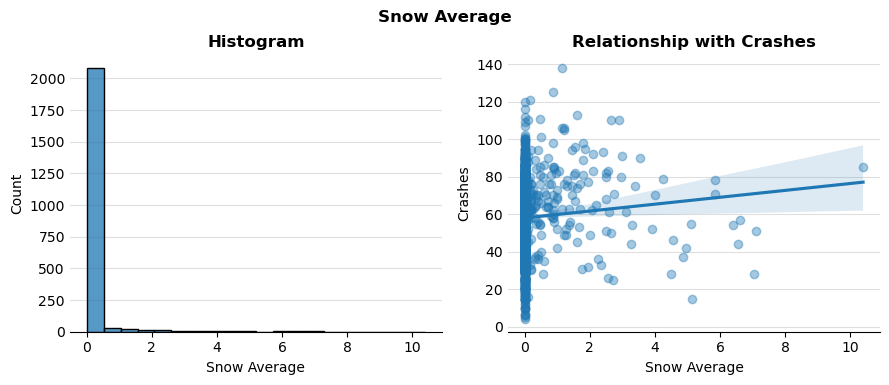

In [27]:
#snow average
plot_df = wdf.copy()
fig,axes = plt.subplots(1,2, figsize = (9,4))
sns.histplot(x = 'snow_avg', data = plot_df, ax = axes[0], bins = 20)
axes[0].set_title('Histogram', weight = 'bold')
sns.regplot(x = 'snow_avg', y = 'crashes', data = plot_df, 
                scatter_kws = {'alpha':0.4}, ax = axes[1])
axes[1].set_title('Relationship with Crashes', weight = 'bold')
axes[1].set_ylabel('Crashes')
rmv_spines = ['top','right','left']
for ax in axes:
    ax.set_axisbelow(True)
    ax.grid(axis = 'y', alpha = 0.4)
    ax.tick_params(axis = 'y', length = 0)
    for s in rmv_spines:
        ax.spines[s].set_visible(False)
    ax.set_xlabel('Snow Average')
fig.suptitle('Snow Average', weight = 'bold', y = 0.95) 
fig.tight_layout()

Below we check whether any of the transformations of the `snow_avg` variable could potentially be more useful from a modeling perspective. R-squared values, included in each chart, suggest that these snow variables by themselves explain a very small proportion of the variation in the number of daily crashes, and their predictive power may therefore be limited. 

From a comparative perspective, the transformed variables tend to explain a larger proportion of the variation in crashes than the untransformed `snow_avg` variable, with the log-transformed second-order polynomial explaining the largest proportion, about 2.75 percent. The plots of the second-order polynomials suggest an inverted U-shapeed relationship. If we were to take this curve at face value, it would indicate that a small to moderate amount of snow results in more crashes, but at a certain point the number of crashes begins to decline as the volume of snow increases. To explain this, we might reason that while snow makes the roads more hazardous, if there is a sufficient amount of it, people take precautions such as avoiding travel, thereby minimizing the potential for crashes.

One risk always worth keeping in mind when using polynomials is that they can increase the risk of overfitting, and making unrealistic estimates when extrapolating beyond the range of values that exist among the predictors in the training data. For example, the best-fit line in the plot on the upper right would start to estimate a <i>negative</i> number of crashes when snow volumes exceed about 12 inches. 

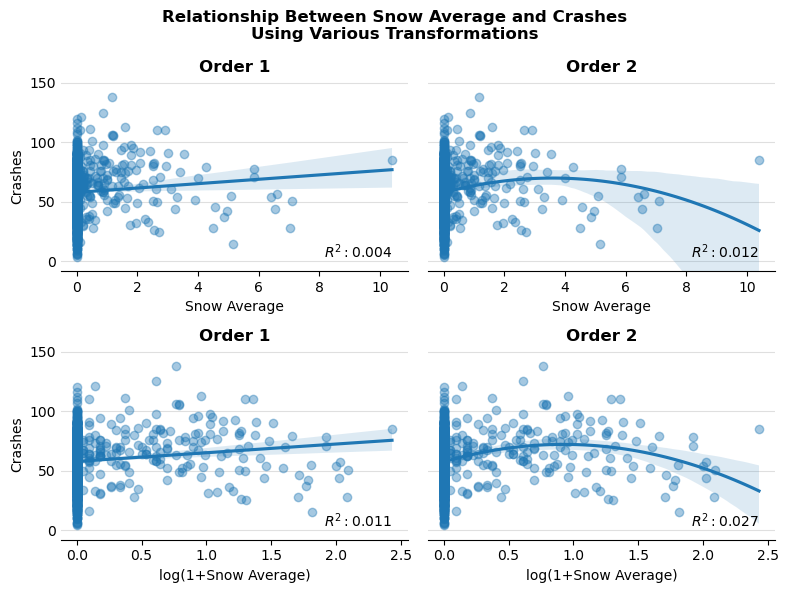

In [28]:
#linear, log, each with polynomial orders 1,2,3
plot_df = wdf.copy()
rmv_spines = ['top','right','left']
vrs = ['snow_avg','log_snow_avg']
orders = [1,2]
fig, axes = plt.subplots(2,2,figsize = (8,6), sharey = True)
xlabs = ['Snow Average', 'log(1+Snow Average)']
for v,xlab,ax_row in zip(vrs,xlabs,axes):
    for i,(order,ax) in enumerate(zip(orders,ax_row)):
        sns.regplot(x = v, y = 'crashes', data = plot_df, order = order, ax = ax, 
                    scatter_kws = {'alpha':0.4})
        preds = [v]
        if order == 2:
            preds += [v+'_2']
        r2 = get_r2(data = plot_df, preds = preds, target = 'crashes')
        ax.text(x = plot_df[preds[0]].max(), y = 0,#plot_df['crashes'].median()*1.5, 
                s = r'$R^2: {}$'.format(round(r2,3)), ha = 'right', va = 'bottom') 
        ax.set_ylim(-8,plot_df['crashes'].max()*1.1)
        ax.set_title(f'Order {i+1}', weight = 'bold')
        ax.set_ylabel('Crashes')
        if i != 0:
            ax.set_ylabel('')
        for s in rmv_spines:
            ax.spines[s].set_visible(False)
        ax.set_axisbelow(True)
        ax.grid(axis = 'y', alpha = 0.4)
        ax.tick_params(axis = 'y', length = 0)
        ax.set_xlabel(xlab)
fig.suptitle('Relationship Between Snow Average and Crashes\nUsing Various Transformations', 
             weight = 'bold', y = 0.98)
fig.tight_layout()

So these snowfall variables do not appear to be powerful unilateral predictors of the daily number of crashes, but we will see whether any of them can add value to our time-series models.

### Model Training and Forecasting

Before we start the modeling process we will take a few steps to prepare the main dataframe that will be used for modeling, `df`. This dataframe contains variables corresponding to the date and number of crashes, `ds` and `y`, respectively, as well as each of the five snow variables that were explored above. It contains all of the data for the training and testing periods, as the modeling classes defined below will partition the data into training and testing sets internally as needed.

In [29]:
#make dataset that will be used for modeling

#get crashes for each day included in the data
daily_crashes = crash_df.groupby('DATE').size()
#apply transformations previous applied to training data to all weather data
weather_preds = ['snow_binary','snow_avg','snow_avg_2','log_snow_avg','log_snow_avg_2']
w_df = make_weather_wide(weather_df)
w_df = weather_mt_to_nan(w_df)
w_df = make_snow_vars(w_df)
w_df = w_df[['date']+weather_preds].rename(columns = {'date':'ds'}) 
w_df['ds'] = pd.to_datetime(w_df['ds'])
#make main df for modeling, containing crashes and dates, and merge weather data with it
df = pd.DataFrame({'ds':daily_crashes.index,
                   'y':daily_crashes.to_list()})
df = df.merge(w_df, how = 'left', on = 'ds')
print('Main Modeling Dataset:')
print('Dimensions:',df.shape)
display(df.head())
print('...')

Main Modeling Dataset:
Dimensions: (2556, 7)


,ds,y,snow_binary,snow_avg,snow_avg_2,log_snow_avg,log_snow_avg_2
0,2013-01-01,46,0,0.0,0.0,0.0,0.0
1,2013-01-02,53,0,0.0,0.0,0.0,0.0
2,2013-01-03,57,0,0.0,0.0,0.0,0.0
3,2013-01-04,62,0,0.0,0.0,0.0,0.0
4,2013-01-05,51,0,0.0,0.0,0.0,0.0


...


Recall also that we have holidays contained in `holidays_df`. Similar to the snow data, holidays will be used as exogenous variables, but will be fed into the modeling classes separately and combined as with the main `df` dataframe within the modeling classes as needed. 

The Prophet model is designed to take `holidays_df` as input directly, but the holiday data will need to be reformated into dummy variables for the `statsmodels` implemtation of SARIMAX. This reformatting is applied below, and the dummy variables are stored in the `holiday_dummies` dataframe.

In [30]:
print('Holiday Data for Prophet:')
print('Dimensions:',holidays_df.shape)
display(holidays_df.head())
print('...')
print()
holiday_dummies = pd.get_dummies(holidays_df['holiday'], columns = 'holiday')
holiday_dummies = holidays_df[['ds']].merge(holiday_dummies, how = 'left', left_index = True, right_index = True)
print('Holiday Data for SARIMAX:')
print('Dimensions:',holiday_dummies.shape)
display(holiday_dummies.head())
print('...')

Holiday Data for Prophet:
Dimensions: (75, 2)


,ds,holiday
0,2013-01-01,New Year's Day
1,2013-01-21,Martin Luther King Jr. Day
2,2013-02-18,Washington's Birthday
3,2013-05-27,Memorial Day
4,2013-07-04,Independence Day


...

Holiday Data for SARIMAX:
Dimensions: (75, 15)


,ds,Christmas Day,Christmas Day (Observed),Columbus Day,Independence Day,Independence Day (Observed),Labor Day,Martin Luther King Jr. Day,Memorial Day,New Year's Day,New Year's Day (Observed),Thanksgiving,Veterans Day,Veterans Day (Observed),Washington's Birthday
0,2013-01-01,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,2013-01-21,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,2013-02-18,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2013-05-27,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,2013-07-04,0,0,0,1,0,0,0,0,0,0,0,0,0,0


...


#### SARIMAX

The first modeling approach we will explore is the classical SARIMAX framework. A `SarimaxModeler` class is defined below to assist with the modeling process. It contains methods for model training, parameter exploration, goodness-of-fit checks, and generating simple forecasts for a set number of periods as well as expanding window forecasts.

In [31]:
class SarimaxModeler:
    #constructor
    def __init__(self, data, exog_vars = False, holidays_df = False):
        
        #handle exog vars
        if type(exog_vars)==list:
            self.exog_vars = exog_vars
        elif exog_vars == False:
            self.exog_vars = []
        self.data = data[['ds','y']+self.exog_vars].copy()
        
        #handle holidays_df
        if type(holidays_df) == pd.DataFrame:
            self.holidays_df = holidays_df.copy()
            self.holiday_vars = [i for i in holidays_df.columns if i!='ds']
            self.data = self.data.merge(holidays_df, how = 'left', on = 'ds').fillna(0)
        elif holidays_df == False:
            self.holidays_df = holidays_df
            self.holiday_vars = []
        
        #set other attributes to False or None
        self.trained = False
        self.trained_model = None
        self.train_period = None
        self.train_df = None
        self.forecast_df = None 
        self.aic = None
        self.param_aics = None
        
    #train method
    def train(self, train_period, order, seasonal_order,  
              warn = False, store_model = True, return_model = True, store_aic = True):
        #store train_period
        self.train_period = train_period
        #create training dataset
        train_df = self.data[(self.data['ds']>=train_period[0])&(self.data['ds']<=train_period[1])]\
                       .reset_index(drop = True).copy()
        #store train_df
        self.train_df = train_df.copy()
        
        #define exog and exog_names
        if (self.exog_vars == []) and (self.holiday_vars == []):
            exog = None
            exog_names = None
        else:
            exog = train_df[self.exog_vars+self.holiday_vars]#.to_numpy()
            exog_names = self.exog_vars+self.holiday_vars
        
        #train model
        try:
            if warn == False:
                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore')

                    model = SARIMAX(endog = train_df['y'],#.to_numpy(), 
                                      exog = exog,
                                      exog_names = exog_names,
                                      order = order, 
                                      seasonal_order = seasonal_order,
                                      maxiter = 5000, initialization = 'approximate_diffuse').fit(disp=False)
            else:
                model = SARIMAX(endog = train_df['y'],#.to_numpy(), 
                                  exog = exog,
                                  exog_names = exog_names,
                                  order = order, 
                                  seasonal_order = seasonal_order,
                                  maxiter = 5000, initialization = 'approximate_diffuse').fit(disp=False)
                
        except:
            print(f'Error for order, seasonal_order: {order},{seasonal_order}')
            #store model/aic if applicable
            if store_model:
                self.trained_model = None
            if store_aic:
                self.aic = None
            return None
        
        #store model/aic if applicable
        if store_model:
            self.trained_model = model
        if store_aic:
            self.aic = model.aic
        
        #indicate a model has been trained
        self.trained = True
        
        #return model if applicable
        if return_model:
            return model
        
    #explore_params method
    def explore_params(self, train_period, pdqPDQs, return_aics = True, store_aics = True):
        #list for storing AICs
        AICs = []
        #iterate through all given param combos
        for pi,di,qi,Pi,Di,Qi,si in pdqPDQs:
            model = self.train(train_period = train_period, order = (pi,di,qi), seasonal_order = (Pi,Di,Qi,si))
            AICs.append(self.aic)
        #sort aics with corresponding params and assign to dataframe
        param_aics = pd.DataFrame({'params':pdqPDQs, 'AIC':AICs}).sort_values('AIC', ignore_index = True)
        #store aics if applicable
        if store_aics:
            self.param_aics = param_aics
        #return dataframe if applicable
        if return_aics:
            return param_aics
        
    #gof method
    def gof(self, trained_model = False, return_results = True, plot = True, ljung_box_lags = 10):
        assert_str = 'trained_model must be provided if training has not already been performed.'
        assert self.trained or trained_model==sm.tsa.statespace.sarimax.SARIMAXResultsWrapper, assert_str
        
        #define model that will be used based on whether a trained_model has been provided
        if trained_model == False:
            trained_model = self.trained_model
        
        #plot gof visuals
        if plot:
            fig = trained_model.plot_diagnostics(figsize = (8,8), lags = ljung_box_lags)
            plt.show() 
        
        #display Ljung-Box results
        residuals = trained_model.resid
        lb_results = acorr_ljungbox(residuals, lags = ljung_box_lags)
        
        #return residuals if applicable
        if return_results:
            return {'residuals':residuals,'lb_test':lb_results}
    
    #forecast method
    def forecast(self, periods, interval_width = 0.95, trained_model = False, 
                 store_forecast = False, return_results = True):
        #use trained_model if given
        if type(trained_model)==sm.tsa.statespace.sarimax.SARIMAXResultsWrapper:
            mod = trained_model
        #else use self.trained_model
        elif type(self.trained_model)==sm.tsa.statespace.sarimax.SARIMAXResultsWrapper:
            mod = self.trained_model
        #else print error
        else:
            print('Error: Trained model must be provided or previously stored.')
            
        #get forecast exog data
        if periods==1:
            forecast_period = [self.train_period[1]+pd.DateOffset(days = 1),
                               self.train_period[1]+pd.DateOffset(days = 1)]
        else:
            forecast_period = [self.train_period[1]+pd.DateOffset(days = 1),
                               self.train_period[1]+pd.DateOffset(days = periods)]
        forecast_filt = (self.data['ds']>=forecast_period[0])&(self.data['ds']<=forecast_period[1])
        forecast_df = self.data[forecast_filt].reset_index(drop = True)
        self.forecast_df = forecast_df
        
        #make forecast
        if periods==1:
            forecast = mod.get_forecast(2, 
                     exog = np.concatenate((self.forecast_df[self.exog_vars+self.holiday_vars],#.to_numpy(),
                                            self.forecast_df[self.exog_vars+self.holiday_vars])),#.to_numpy())),
                     alpha = 1 - interval_width)
            preds = [forecast.predicted_mean.tolist()[0]]
            lower,upper = forecast.conf_int()['lower y'].tolist()[:1], forecast.conf_int()['upper y'].tolist()[:1]
        else:
            forecast = mod.get_forecast(periods, 
                                        exog = forecast_df[self.exog_vars+self.holiday_vars],#.to_numpy(),
                                        alpha = 1 - interval_width)
            preds = forecast.predicted_mean.tolist()
            lower,upper = forecast.conf_int()['lower y'].tolist(), forecast.conf_int()['upper y'].tolist()
            
        #return results
        result = {'preds':preds,'upper':upper, 'lower':lower}
        return result
    
    #expanding_window_forecast method
    def expanding_window_forecast(self, init_train_period, order, seasonal_order, step_size, 
                                  interval_width = 0.95, plot = True, 
                                  plot_title = 'SARIMAX Forecast', return_metrics = True):
        #specify training period
        train_period = init_train_period.copy()

        #define test dataset
        test_df = self.data[self.data['ds']>train_period[1]].copy()
        #define test period target values
        y_test = pd.DataFrame({'y':test_df['y'].to_list()}, index = test_df['ds'])
        #define remaining test days
        remaining_test_days = len(y_test['y'])
        #lists to store forecast results
        preds = []
        ub = []
        lb = []
        
        #iterate
        iterations = int(np.ceil((remaining_test_days/step_size)))
        for i in range(iterations):
            #make training data
            train_filt_i = (self.data['ds']>=train_period[0])&(self.data['ds']<=train_period[1])
            train_df_i = self.data[train_filt_i].reset_index(drop = True)
            #specify forecast length
            forecast_len = min(step_size,remaining_test_days)
            #train model
            model = self.train(train_period = train_period, 
                               order = order, 
                               seasonal_order = seasonal_order)
            forecast = self.forecast(periods = forecast_len, interval_width = interval_width)
            preds += forecast['preds']
            ub += forecast['upper']
            lb += forecast['lower']
            #adjust training period and remaining days
            train_period[1] = train_period[1]+pd.DateOffset(days = step_size)
            remaining_test_days -= step_size
        #calculate forecast metrics
        coverage = np.mean([i<=u and i>=l  for i,u,l in zip(y_test['y'],ub,lb)])
        mae = mean_absolute_error(y_test['y'].to_list(), preds)
        rmse = mean_squared_error(y_test['y'].to_list(), preds, squared = False)
        raw_errors = y_test['y'].to_numpy() - np.array(preds)
        #plot if applicable
        if plot:
            preds = pd.Series(preds, index = test_df['ds'])
            ub = pd.Series(ub, index = test_df['ds'])
            lb = pd.Series(lb, index = test_df['ds'])
            fig, ax = plt.subplots(1,1,figsize = (15,5))
            ax.plot(y_test['y'], color = 'black', alpha = 0.5, label = 'True Values')
            ax.plot(preds, color = 'C0', label = 'Forecast')
            ax.fill_between(x = preds.index, y1 = ub, y2 = lb, 
                            color = 'C0', alpha = 0.1, label = f'{interval_width*100}% PI')
            ax.set_ylabel('Crashes')
            ax.legend(ncol = 3)
            fig.suptitle(plot_title, weight = 'bold', size = 18, x = 0.05, y = 0.85, ha = 'left')
            ax.set_title(f'MAE: {round(mae,4)}\nRMSE: {round(rmse,4)}\nCoverage: {round(coverage*100,2)}%', 
                         loc = 'right')
            fig.tight_layout()
            plt.show() 
        #return metrics if applicable
        if return_metrics:
            return {'mae':mae,'rmse':rmse,'coverage':coverage,'errors':raw_errors}

We will create a number of different SARIMAX models, each with a different set of predictors, defined below. One model will not have any exogenous predictors (i.e., endogenous only). Technically, this will be a SARIMA model, since there is no <i>eXogenous</i> component. The next model will incorporate the holiday variables. Then, each of the snow variables created previously will be used to create two models &mdash; one with just the snow variable(s) and one with the snow variable(s) in combination with the holidays. 

In [32]:
#specify input variables for each sarimax model
mod_info_s = [
              {'title':'SARIMAX Forecast\n(Endogenous Only)',
                   'exog_vars':False,
                   'holidays_df':False},
              {'title':'SARIMAX Forecast\n(w/ Holidays)',
                   'exog_vars':False,
                   'holidays_df':holiday_dummies},
              {'title':'SARIMAX Forecast\n(w/ Snow Binary)',
                   'exog_vars':['snow_binary'],
                   'holidays_df':False},
              {'title':'SARIMAX Forecast\n(w/ Snow Binary & Holidays)',
                   'exog_vars':['snow_binary'],
                   'holidays_df':holiday_dummies},
              {'title':'SARIMAX Forecast\n(w/ Snow Avg)',
                   'exog_vars':['snow_avg'],
                   'holidays_df':False},
              {'title':'SARIMAX Forecast\n(w/ Snow Avg & Holidays)',
                   'exog_vars':['snow_avg'],
                   'holidays_df':holiday_dummies},
              {'title':'SARIMAX Forecast\n(w/ Snow Avg^2)', 
                   'exog_vars':['snow_avg','snow_avg_2'],
                   'holidays_df':False},
              {'title':'SARIMAX Forecast\n(w/ Snow Avg^2 & Holidays)',
                   'exog_vars':['snow_avg','snow_avg_2'],
                   'holidays_df':holiday_dummies},
              {'title':'SARIMAX Forecast\n(w/ Log Snow Avg)',
                   'exog_vars':['log_snow_avg'],
                   'holidays_df':False},
              {'title':'SARIMAX Forecast\n(w/ Log Snow Avg & Holidays)',
                   'exog_vars':['log_snow_avg'],
                   'holidays_df':holiday_dummies},
              {'title':'SARIMAX Forecast\n(w/ Log Snow Avg^2)',
                   'exog_vars':['log_snow_avg','log_snow_avg_2'],
                   'holidays_df':False},
              {'title':'SARIMAX Forecast\n(w/ Log Snow Avg^2 & Holidays)',
                   'exog_vars':['log_snow_avg','log_snow_avg_2'],
                   'holidays_df':holiday_dummies}
             ]

SARIMAX takes a number of parameters that are specified in advance of model training (i.e., hyperparameters). We will train each model over a range of hyperparameter options, and choose those that minimize Akaike Information Criterion (AIC) score on the training data and have an Ljung-Box test p-values $> 0.05$, both overall and individually for 10 lags.<a name="cite_ref-9"></a>[<sup>[9]</sup>](#cite_note-9)<a name="cite_ref-10"></a>[<sup>[10]</sup>](#cite_note-10) If a set of hyperparameters produces a model that does not meet the Ljung-Box test criteria, the hyperparameters that achieve the next best AIC score are used. 

The AIC score rewards a model's ability to fit the data, and incorporates a penalty for model complexity. Ljung-Box tests check for autocorrelation in the residuals. We do not apply criteria related to the Jarque-Bera test of normality with respect to the residuals, but we will examine visualizations of the residuals to gain some basic insight into the degree to which the residuals diverge from the normal distribution.

The hyperparameters that will be included in the search are:
 - Autoregressive order, $p \in \{0,1,2,3\}$.
 - Differencing order, $d = 0$. Recall that the ADF test suggested non-seasonal differencing was not necessary.
 - Moving average order $q \in \{0,1,2,3\}$.
 - Seasonal autoregressive order, $P \in \{0,1,2,3\}$.
 - Seasonal differencing order, $D \in \{0,1\}$.
 - Seasonal moving average order, $Q \in \{0,1,2,3\}$.
 - Seasonal period $s = 7$. This reflects weekly seasonality identified previously in the exploratory analysis.

While it would be ideal to use cross-validation and to explore a broader range of hyperparemters, this procedure is applied to this limited range of hyperparameter values for the sake of computational speed, given that we are working with several sets of predictors.

The below cell defines these hyperparameters and the training period that will be fed into the modeler class's `train()` method for each set of predictors.

<a name="cite_note-9"></a><font size = "1.5">9. [^](#cite_ref-9) </font></a><font size = "1.5">Akaike, H. (1974). "A New Look at the Statistical Model Identification." <i>IEEE Transactions on Automatic Control</i>, 19(6), 716-723, doi: 10.1109/TAC.1974.1100705.</font><br> 
<a name="cite_note-10"></a><font size = "1.5">10. [^](#cite_ref-10) </font></a><font size = "1.5">Ljung, G. M., & Box, G. E. P. (1978). "On a Measure of Lack of Fit in Time Series Models." <i>Biometrika</i>, 65(2), 297–303. doi: 10.2307/2335207.</font><br> 

In [33]:
#specify hyperparams to explore
p = q = P = Q = list(range(4))
d = list(range(1))
D = list(range(2))
s = list(range(7,8))
pdqPDQs = list(itertools.product(p,d,q,P,D,Q,s))

#specify train_period
train_period = [pd.to_datetime('2013-01-01'), pd.to_datetime('2018-12-31')]

The following cell explores all of these hyperparameters for each predictor set and stores the results.

In [34]:
#explore hyperparams and store results
for i in mod_info_s:
    #explore
    smx = SarimaxModeler(data = df, exog_vars = i['exog_vars'], holidays_df = i['holidays_df'])
    aics = smx.explore_params(train_period = train_period, pdqPDQs = pdqPDQs)
    #store 
    i['modeler'] = smx
    i['aics'] = aics

The next cell identifies the hyperparameters that achieve the best AIC scores and meet the Ljung-Box test criteria. It also generates visualizations of the residuals that help examine the models' goodness-of-fit. Only one model's predictor set that yields the best AIC score does not meet the Ljung-Box criteria, requiring the use of predictors that produce the second-best AIC score. This is the model that uses the squared snow average coupled with the holidays as exogenous predictors.

Examining the goodness-of-fit visualizations, we see that the residuals are not quite normally distributed. They appear leptokurtic, with greater density at the center and somewhat longer tails. They also have slightly positive central tendencies, suggesting they may underestimate the number of crashes on average. However, they are unimodal and roughly symmetric, and their divergence from normality does not seem to be too dramatic. We will proceed with using these models to make predictions on the testing set and see how they perform.

SARIMAX Forecast
(Endogenous Only)...


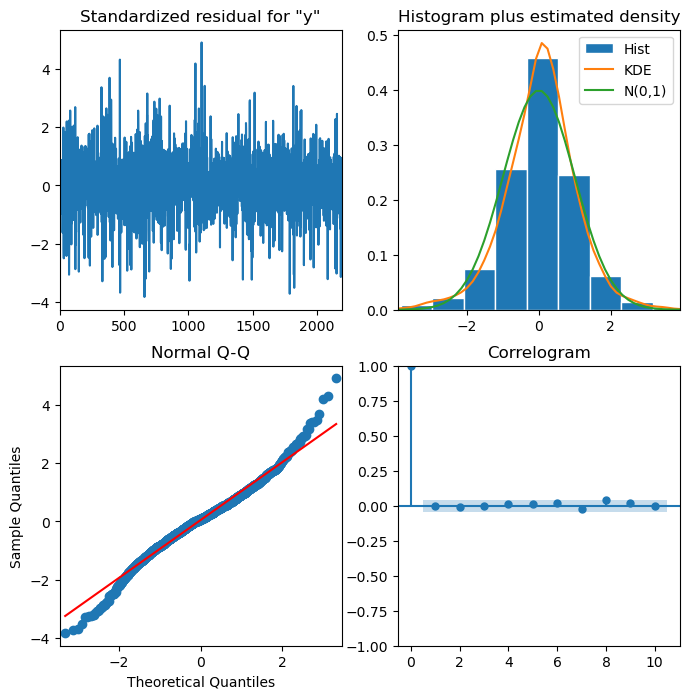

SARIMAX Forecast
(w/ Holidays)...


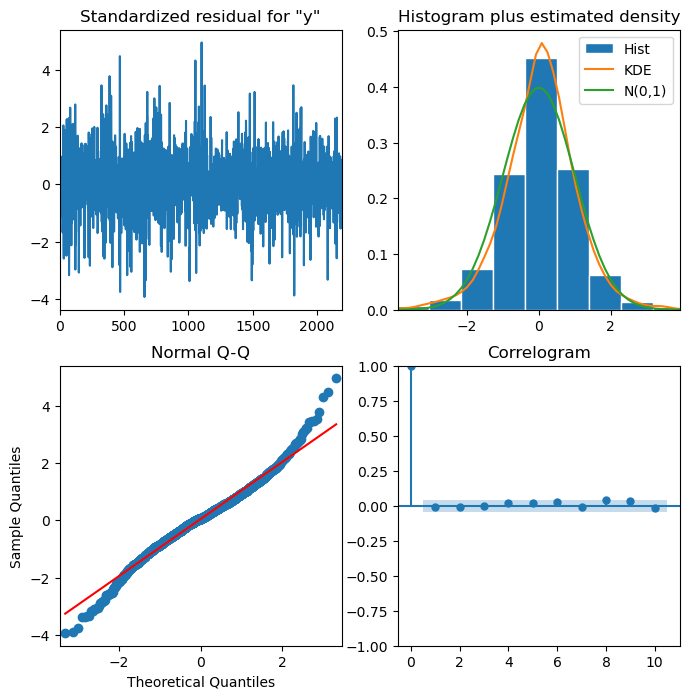

SARIMAX Forecast
(w/ Snow Binary)...


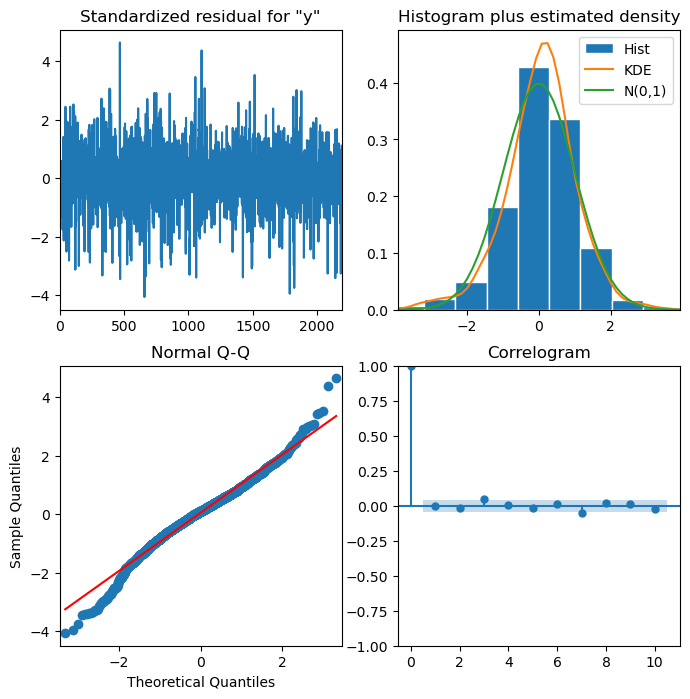

SARIMAX Forecast
(w/ Snow Binary & Holidays)...


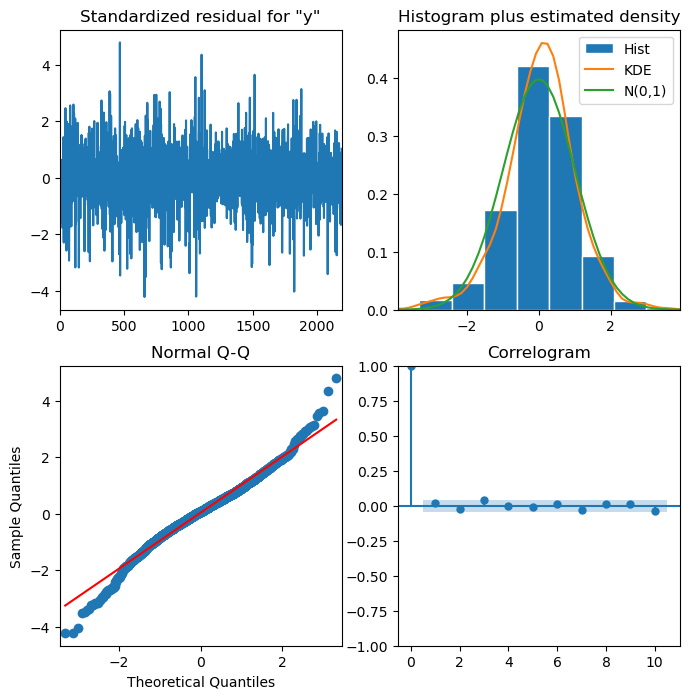

SARIMAX Forecast
(w/ Snow Avg)...


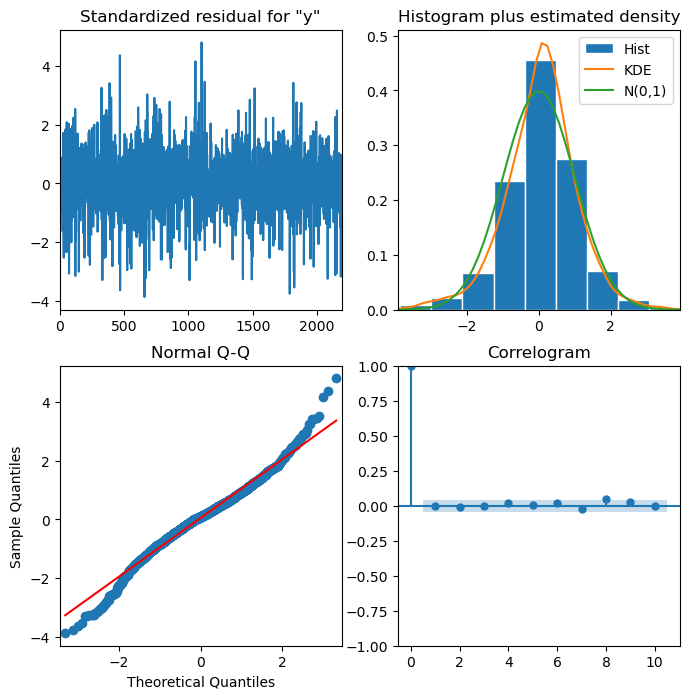

SARIMAX Forecast
(w/ Snow Avg & Holidays)...


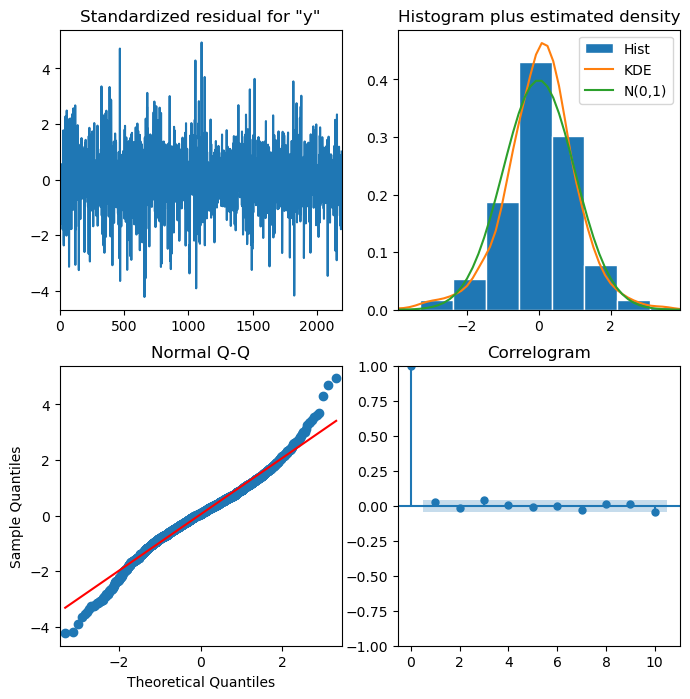

SARIMAX Forecast
(w/ Snow Avg^2)...


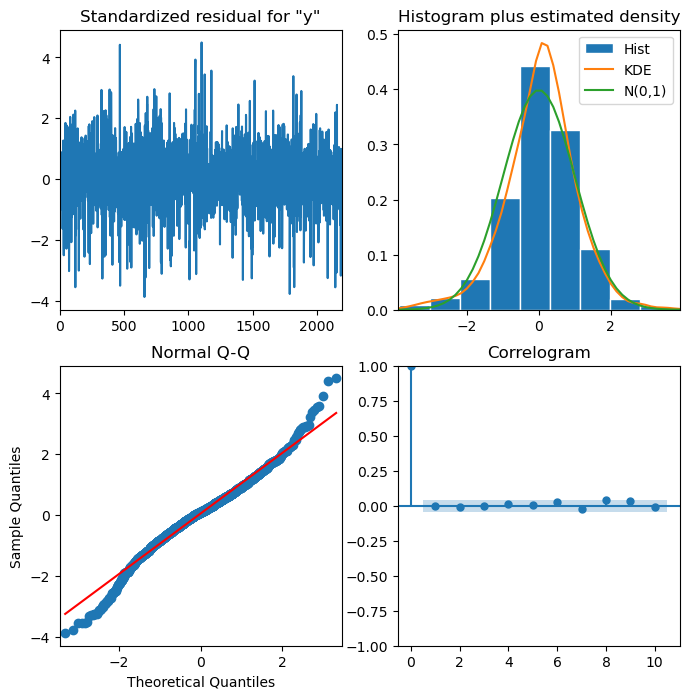

SARIMAX Forecast
(w/ Snow Avg^2 & Holidays)...


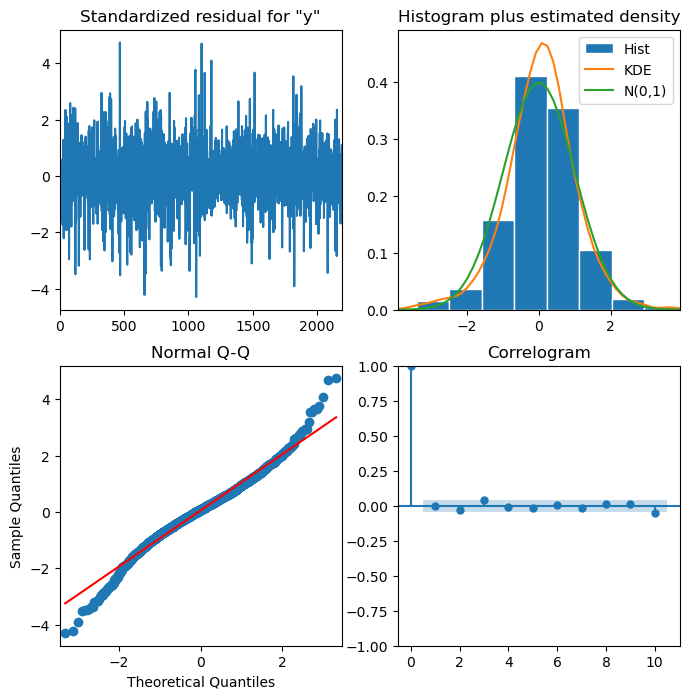

SARIMAX Forecast
(w/ Log Snow Avg)...


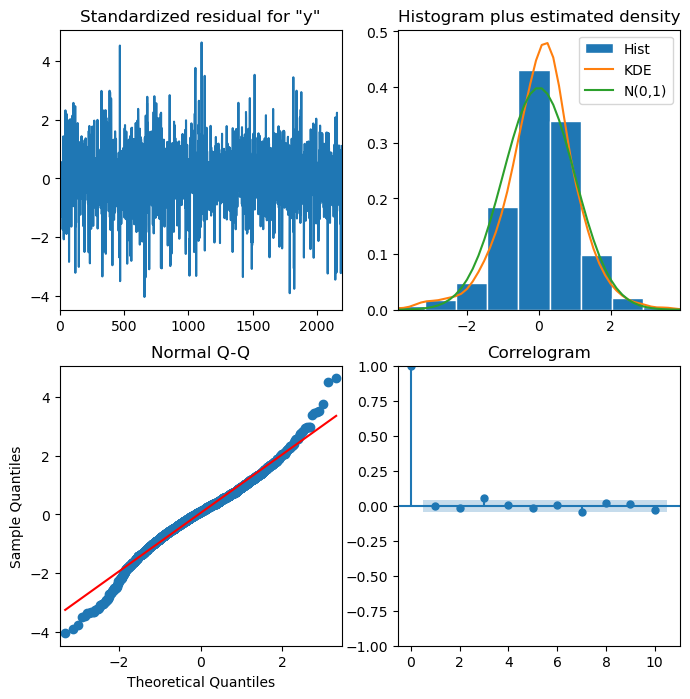

SARIMAX Forecast
(w/ Log Snow Avg & Holidays)...


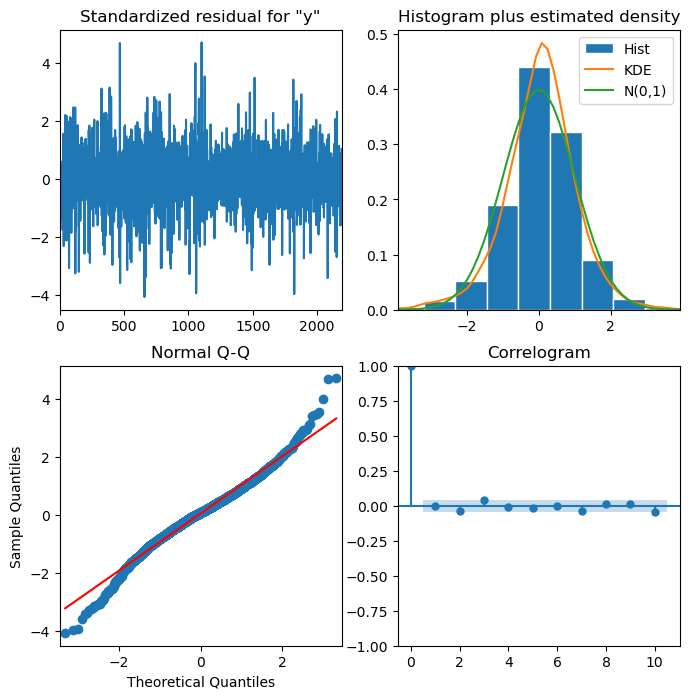

SARIMAX Forecast
(w/ Log Snow Avg^2)...


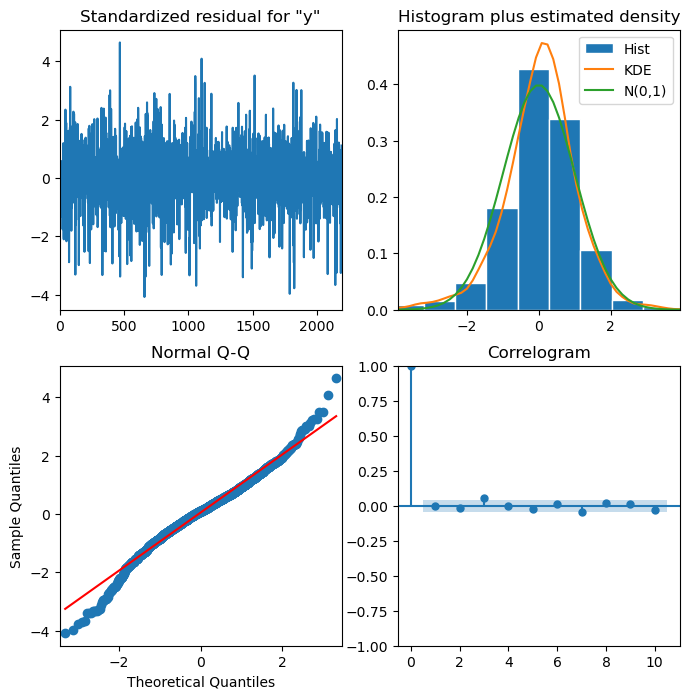

SARIMAX Forecast
(w/ Log Snow Avg^2 & Holidays)...


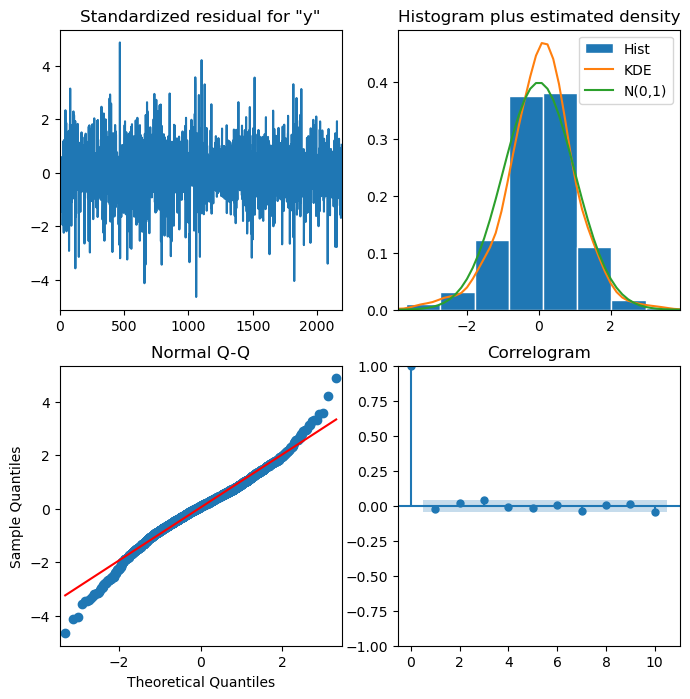

In [35]:
#goodness of fit checks
alpha = 0.05
for i in mod_info_s:
    print(i['title']+'...')
    #set best params based on minimal aic
    idx = 0
    iterate = True
    while iterate:
        #train using best params and assess GOF
        best_p,best_d,best_q,best_P,best_D,best_Q,best_s = i['aics'].iloc[idx]['params']
        model = i['modeler'].train(train_period = train_period, 
                               order = (best_p,best_d,best_q), 
                               seasonal_order = (best_P,best_D,best_Q,best_s))
        gof_results = i['modeler'].gof(plot = False) 
        #if lb criteria are met...
        c1 = float(pd.DataFrame(model.summary().tables[2]).loc[1,1].data)>alpha
        c2 = (gof_results['lb_test']['lb_pvalue']>alpha).all()
        if (c1) and (c2):
            #save model
            i['trained_model'] = model
            #save idx where params are stored, and stop incrementing idx
            i['best_params_idx'] = idx
            #save best aic
            i['best_aic'] = i['aics'].iloc[idx]['AIC']
            #save best order and best seasonal order
            i['best_order'] = (best_p,best_d,best_q)
            i['best_seasonal_order'] = (best_P,best_D,best_Q,best_s)
            #display goodness of fit visuals
            gof_results = i['modeler'].gof(plot = True)
            iterate = False
        #else increment idx
        else:
            idx += 1

In [36]:
#check how many times the Ljung-Box criteria were not met
forced_param_switch = [i['title'] for i in mod_info_s if i['best_params_idx']!=0]
print('Predictors that produced at least one model that did not meet the Ljung-Box criterion:')
print(forced_param_switch)
num_switches = [i['best_params_idx'] for i in mod_info_s if i['best_params_idx']!=0]
print(f'...Had to switch {num_switches} times.')

Predictors that produced at least one model that did not meet the Ljung-Box criterion:
['SARIMAX Forecast\n(w/ Snow Avg^2 & Holidays)']
...Had to switch [1] times.


The below visualization shows the AIC scores for each model, ordered from lowest to highest AIC. The model using only endogenous data with no exogenous predictors had the highest AIC score, while the model using the second-order, log-transformed snow average combined with the holidays achieved the lowest. In addition to this, we can see that the models that used the holidays as predictors consistently outperformed those that did not.

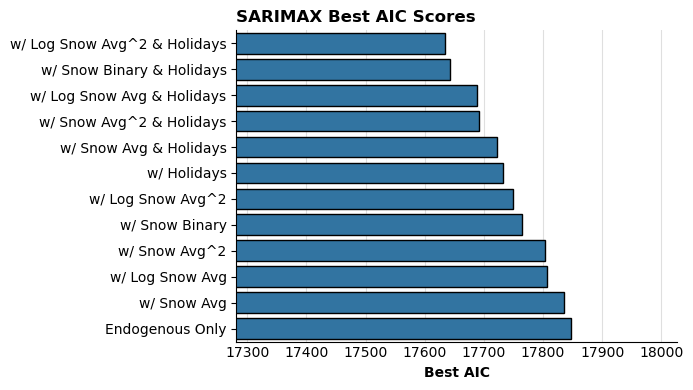

In [37]:
#plot aics
best_aics = [i['best_aic'] for i in mod_info_s]
titles = [re.sub(r'SARIMAX Forecast\n\(|\)', '', i['title']) for i in mod_info_s]
plot_df = pd.DataFrame({'':titles, 'Best AIC':best_aics}).sort_values('Best AIC', ascending = True)
fig, ax = plt.subplots(1,1,figsize = (7,4))
sns.barplot(y = '', x = 'Best AIC', data = plot_df, ax = ax,
            color = 'C0', edgecolor = 'black')
ax.set_xlim(plot_df['Best AIC'].min()*0.98, plot_df['Best AIC'].max()*1.01)
ax.set_xlabel('Best AIC', weight = 'bold')
rmv_spines = ['top','right']
ax.set_axisbelow(True)
ax.grid(axis = 'x', alpha = 0.4)
ax.tick_params(axis = 'x', length = 0)
for s in rmv_spines:
    ax.spines[s].set_visible(False)
ax.set_title('SARIMAX Best AIC Scores', weight = 'bold', ha = 'left', x = 0)
fig.tight_layout()

Below we can examine a summary of the model that yields the best AIC. This is a $\text{SARIMAX}(p=2,d=0,q=1)(P=0,D=1,Q=1,s=7)$ model that used exogenous predictors `log_snow_avg`, `log_snow_avg_2`, as well as the holiday dummy variables. We can see that the snow variables are statistically significant. The coefficient of the squared term is negative while the coefficient of the non-squared term is positive, which we would expect given the inverted U-shaped relationship with the number of crashes observed in the exploratory analysis. 

Several of the holidays are statistically significant at the 0.01 level with large negative coefficients, such as Thanksgiving Day, Labor Day and Christmas Day (as well as Christmas Day observed), implying fewer crashes on these days, holding the snow variables constant. Others such as Washington's Birthday and Martin Luther King Jr. Day are not statistically significant at the 0.01 or 0.05 level. All holiday coefficient estimates are negative, with the exception of Martin Luther King Jr. Day. 

The endogenous predictors &mdash; including the two autoregressive variables, the the one moving-average variable, and the seasonal moving-average variable &mdash; are all statistically significant at the 0.001 level. 

We should note that this only summarizes the model as it was fit to the training set, and these coefficients are subject to change as the model's training window expands into 2019 at each two-week interval.

In [38]:
#show summary of model having best AIC score
best_aic_model = mod_info_s[np.argmin([i['best_aic'] for i in mod_info_s])]['trained_model']
best_aic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 2191
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 7)   Log Likelihood               -8796.083
Date:                             Wed, 25 Oct 2023   AIC                          17634.166
Time:                                     18:21:25   BIC                          17753.701
Sample:                                          0   HQIC                         17677.855
                                            - 2191                                         
Covariance Type:                               opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
log_snow_avg                   31.4503      2.172     14.482      0.000      27.194      35.707
log_snow_avg_2                -15.6078      1.307    -11.942      0.000     -18.169     -13.046
Christmas Day                 -25.2735      5.052     -5.003      0.000     -35.175     -15.372
Christmas Day (Observed)      -42.2118     15.213     -2.775      0.006     -72.028     -12.395
Columbus Day                   -3.7739      5.618     -0.672      0.502     -14.786       7.238
Independence Day              -18.5638      9.681     -1.918      0.055     -37.537       0.410
Independence Day (Observed)   -21.8086     71.931     -0.303      0.762    -162.791     119.174
Labor Day                     -35.0871      7.902     -4.441      0.000     -50.574     -19.600
Martin Luther King Jr. Day      1.3329      3.249      0.410      0.682      -5.035       7.701
Memorial Day                  -25.3422      6.669     -3.800      0.000     -38.413     -12.272
New Year's Day                -15.7574      7.002     -2.250      0.024     -29.482      -2.033
New Year's Day (Observed)     -24.0959     27.383     -0.880      0.379     -77.765      29.573
Thanksgiving                  -33.1327      4.050     -8.181      0.000     -41.071     -25.195
Veterans Day                   -3.6356      4.620     -0.787      0.431     -12.690       5.419
Veterans Day (Observed)       -17.1300      3.883     -4.412      0.000     -24.740      -9.520
Washington's Birthday          -5.7779      4.731     -1.221      0.222     -15.051       3.496
ar.L1                           0.9696      0.012     83.492      0.000       0.947       0.992
ma.L1                          -0.6965      0.022    -31.331      0.000      -0.740      -0.653
ma.L2                          -0.2075      0.021     -9.871      0.000      -0.249      -0.166
ma.S.L7                        -0.9784      0.006   -168.982      0.000      -0.990      -0.967
sigma2                        172.6525      4.078     42.332      0.000     164.659     180.646
===================================================================================
Ljung-Box (L1) (Q):                   0.99   Jarque-Bera (JB):               254.32
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now that we have selected model hyperparameters, we will use all of these models to make expanding window forecasts on the testing set (i.e., for 2019), and compare their performance in terms of two metrics: RMSE and MAE. Prefernce will be given to the former, as it imposes a greater penalty on large errors. The latter is useful because it is easy to interpret as the average degree to which the model's predictions deviate from the actual number of daily crashes.

Recall that we are using an expanding window approach. The model is initially trained on all data from 2013-2018, then forecasts two-weeks out. It is then retrained over all of the previous dates plus the two-week period for which it just forecasted, and generates a new forecast for the subsequent two-week period, and this process is repeated until a full 2019 forecast is complete.

In [39]:
#specify init_train_period, step_size, and interval_width for expanding window forecasting
init_train_period = train_period.copy()
step_size = 14
interval_width = 0.8
#iterate through models
for i in mod_info_s:
    #make expanding window forecast and store metrics
    i['metrics'] = i['modeler'].expanding_window_forecast(init_train_period = init_train_period, 
                                                    order = i['best_order'], 
                                                    seasonal_order = i['best_seasonal_order'], 
                                                    step_size = step_size, interval_width = interval_width,
                                                    return_metrics = True, plot = False)

The below plot shows how the various models performed. The bar chart on the left shows the RMSE and MAE forecast scores that each set of predictors achieved, ranked in order of lowest RMSE to highest. The model that used Snow Avg$^2$ and holiday predictors achieved the lowest RMSE and MAE. The MAE indicates that its predictions were off by fewer than nine crashes on average. The chart shows a clear difference in performance between models that used holidays as predictors compared to those that did not, most visibly with respect to RMSE. 

The visualization on the right uses a bubble plot to examine the relationship between the models' initial training AIC scores, and their RMSE and MAE forecast scores. It shows that AIC scores roughly correspond to the forecasting metrics, as the bubbles in the upper right quadrant are larger than the bubbles in the lower left, but it is not a perfect correlation &mdash; for example, the predictors that produced the lowest RMSE and MAE scores overall did not have the lowest AIC. This bubble plot also underscores the degree to which model performance is impacted when introducing different predictors. In general, it appears that using the snow predictors can improve performance somewhat, at least with respect to MAE, while using the holiday predictors substantially improves the RMSE. This implies that the holiday predictors help the model avoid some of the large errors that the models make when not taking the holidays into account, as we might expect given the big differences observed in the number of crashes between non-holidays and certain holidays in the exploratory analysis, and the large coefficients for a few of the holidays in the model summary reviewed above.

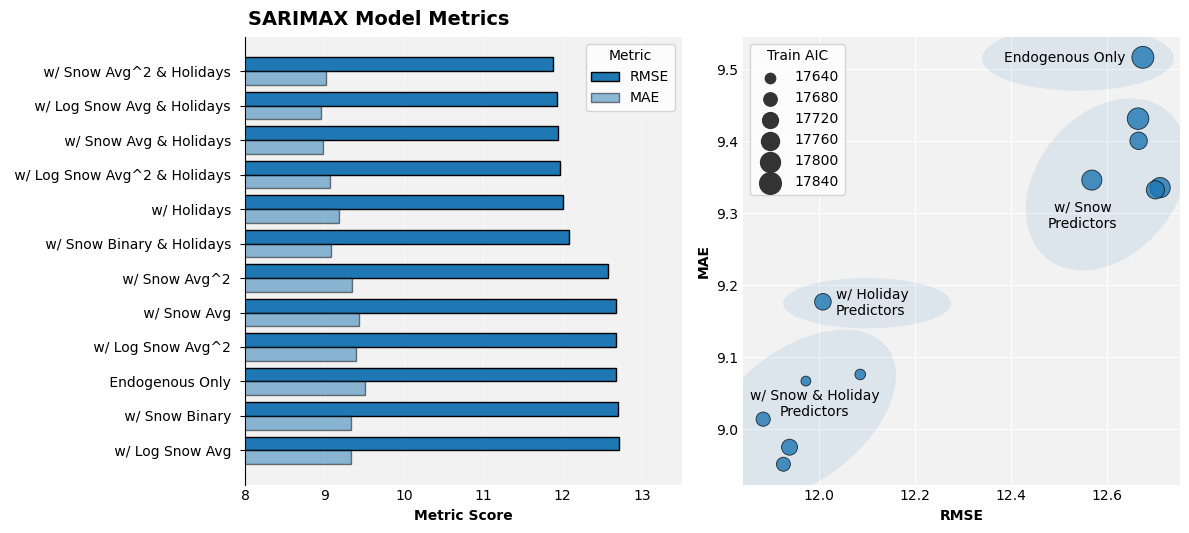

In [40]:
#compare AICs with prediction metrics
plot_df = pd.DataFrame({'title':[re.sub(r'SARIMAX Forecast\n\(|\)',' ',i['title']) for i in mod_info_s],
                        'AIC':  [i['best_aic'] for i in mod_info_s],
                        'MAE':  [i['metrics']['mae'] for i in mod_info_s],
                        'RMSE': [i['metrics']['rmse'] for i in mod_info_s]}).sort_values('RMSE', ascending = False)
#plot
fig, axes = plt.subplots(1,2, figsize = (12,5.5))
#barplot
bh = 0.4
ypos = np.arange(plot_df.shape[0])
axes[0].barh(y = ypos+bh/2, width = plot_df['RMSE'], height = 0.4, color = 'C0', 
        label = 'RMSE', edgecolor = 'black')
axes[0].barh(y = ypos-bh/2, width = plot_df['MAE'], height = 0.4, color = 'C0', alpha = 0.5, 
        label = 'MAE', edgecolor = 'black')
axes[0].set_xlabel('Metric Score', weight = 'bold')
axes[0].set_facecolor((0.95,0.95,0.95))
axes[0].grid(axis = 'x', color = 'white')
axes[0].set_axisbelow(True)
axes[0].set_yticks(ypos, plot_df['title'])
axes[0].set_xlim(8,13.5)
rmv_spines = ['top','right','bottom']
axes[0].set_axisbelow(True)
axes[0].grid(axis = 'x', alpha = 0.4)
axes[0].tick_params(axis = 'x', length = 0)
for s in rmv_spines:
    axes[0].spines[s].set_visible(False)
axes[0].legend(title = 'Metric', loc = 'upper right')
#scatterplot
sns.scatterplot(x = 'RMSE', y = 'MAE', size = 'AIC',  data = plot_df, color = 'C0', alpha = 0.8,
                sizes = (50,250), legend = 'brief', edgecolor = 'black', ax = axes[1])
axes[1].set_xlabel('RMSE', weight = 'bold')
axes[1].set_ylabel('MAE', weight = 'bold')
axes[1].set_facecolor((0.95,0.95,0.95))
axes[1].set_axisbelow(True)
axes[1].grid(color = 'white')
axes[1].legend(title = 'Train AIC', loc = 'upper left')
axes[1].tick_params(axis = 'both', length = 0)
rmv_spines = ['top','right','bottom','left']
for s in rmv_spines:
    axes[1].spines[s].set_visible(False)
#draw ellipses
axes[1].text(x = 12.64, y = 9.51, s ='Endogenous Only', ha = 'right')
axes[1].add_artist(Ellipse(xy = (12.54,9.515), width = .4, height = .09, angle = 0, alpha = 0.1))
axes[1].text(x = 12.55, y = 9.28, s ='w/ Snow\nPredictors', ha = 'center')
axes[1].add_artist(Ellipse(xy = (12.6,9.34), width = .35, height = .22, angle = 20, alpha = 0.1))
axes[1].text(x = 11.99, y = 9.035, s ='w/ Snow & Holiday\nPredictors', ha = 'center', va = 'center')
axes[1].add_artist(Ellipse(xy = (11.96,9.02), width = .42, height = .2, angle = 20, alpha = 0.1))
axes[1].text(x = 12.035, y = 9.175, s ='w/ Holiday\nPredictors', ha = 'left', va = 'center')
axes[1].add_artist(Ellipse(xy = (12.1,9.175), width = .35, height = .07, angle = 0, alpha = 0.1))
fig.suptitle('SARIMAX Model Metrics', weight = 'bold', x = 0.32, y = 0.96, size = 14)
fig.tight_layout()

In [41]:
#export results if applicable
export_results = False
sarimax_results_df = pd.DataFrame({'title':[i['title'].replace('\n',' ') for i in mod_info_s],
                                   'MAE':[i['metrics']['mae'] for i in mod_info_s],
                                   'RMSE':[i['metrics']['rmse'] for i in mod_info_s],
                                   'Coverage':[i['metrics']['coverage'] for i in mod_info_s]})
sarimax_results_df = sarimax_results_df.sort_values('RMSE', ignore_index = True)
if export_results:
    sarimax_results_df.to_csv('sarimax_results.csv', index = False)
    sarimax_results_df.to_excel('sarimax_results.xlsx', index = False)

#### Prophet

Next we will use an alternative time series framework, Prophet. Developed for business applications, its has several advantages including speed and relative ease of use, as well as its ability to handle multiple seasonal effects using a Fourier series.<a name="cite_ref-11"></a>[<sup>[11]</sup>](#cite_note-11) With the SARIMAX model, we opted to focus on weekly patterns, since this stood out prominently in the exploratory analysis, but the Prophet model will automatically handle both weekly and yearly seasonalities.

The `ProphetModeler` class defined below will help us to train our Prophet models and make forecasts, similar to the `SarimaxModeler` class.

<a name="cite_note-11"></a><font size = "1.5">11. [^](#cite_ref-11) </font></a> <font size = "1.5">Taylor SJ, Letham B. 2017. "Forecasting at scale." <i>PeerJ Preprints</i> 5:e3190v2 https://doi.org/10.7287/peerj.preprints.3190v2.
See also: https://facebook.github.io/prophet/.</font><br> 

In [42]:
class ProphetModeler:
    #constructor
    def __init__(self, data, exog_vars = False, holidays_df = False):
        
        if type(exog_vars)==list:
            self.data = data[['ds','y']+exog_vars].copy()
            
        elif exog_vars == False:
            self.data = data[['ds','y']].copy()
        self.exog_vars = exog_vars
        
        if type(holidays_df)==pd.core.frame.DataFrame:
            self.holidays_df = holidays_df.copy()
        else:
            self.holidays_df = holidays_df
            
        self.trained = False
        self.trained_model = None
        self.cross_validated = False
        self.forecast_df = None 
          
    #train method
    def train(self, train_period, 
              interval_width = 0.95, log = False, store_model = True, return_model = True):
        #turn off logging if applicable
        if log == False:
            logger = logging.getLogger('cmdstanpy')
            logger.addHandler(logging.NullHandler())
            logger.propagate = False
            logger.setLevel(logging.CRITICAL)

        tp = {'start': pd.to_datetime(train_period[0]),
              'end'  : pd.to_datetime(train_period[1])}
        
        #make training dataframe based on time window
        train_df = self.data[(self.data['ds']>=tp['start'])&(self.data['ds']<=tp['end'])]\
                       .reset_index(drop = True)
        
        #instantiate model, specify interval width, and holidays if applicable
        if type(self.holidays_df)==pd.core.frame.DataFrame:
            p_model = Prophet(interval_width = interval_width, holidays = self.holidays_df)
        else:
            p_model = Prophet(interval_width = interval_width)

        #add exog regressor(s) to model, if applicable
        if type(self.exog_vars) == list:
            for i in self.exog_vars:
                p_model.add_regressor(i)

        #fit model to training data
        p_model.fit(train_df)
        
        #change trained status
        self.trained = True

        #store trained model if applicable
        if store_model:
            self.trained_model = p_model
        
        #return fitted model if applicable
        if return_model:
            return self.trained_model
        
    #forecast method
    def forecast(self, periods, include_history = False, trained_model = False, 
                 store_forecast = False, return_results = True):
        #use trained_model if given, else use class' pre-trained model
        if type(trained_model)==prophet.forecaster.Prophet:
            mod = trained_model
        elif type(self.trained_model)==prophet.forecaster.Prophet:
            mod = self.trained_model
        else:
            print('Error: Trained model must be provided or previously stored.')
        #create future_df for making forecasts
        future_df = mod.make_future_dataframe(periods = periods, 
                                              include_history = include_history)
        #add endog and exog vars to future df
        future_df = future_df.merge(self.data, how = 'left', on = 'ds')
        #make predictions
        forecast_df = mod.predict(future_df)
        #store forecast_df if applicable
        if store_forecast:
            self.forecast_df = forecast_df
        #return forecast_df if applicable
        if return_results:
            return forecast_df
        
    #expanding_window_forecast method
    def expanding_window_forecast(self, init_train_period, step_size, interval_width = 0.95, 
                                  plot = True, plot_title = 'Prophet Forecast', return_metrics = True):
        #define test dataset
        test_df = self.data[self.data['ds']>init_train_period[1]].copy()
        #define test period target values
        y_test = pd.DataFrame({'y':test_df['y'].to_list()}, index = test_df['ds'])
        #initial train period 
        train_period = init_train_period.copy()
        #define remaining test days
        remaining_test_days = (self.data['ds']>train_period[1]).sum()
        #lists for storing results
        preds = []
        ub = []
        lb = []
        #iterate
        iterations = int(np.ceil(remaining_test_days/step_size))
        for i in range(iterations):
            #train model and get trained model
            trained_model = self.train(train_period = train_period,
                                       interval_width = interval_width)
            #make forecast
            forecast_len = min(step_size,remaining_test_days)
            forecast = self.forecast(periods = forecast_len)
            #store forecasted values, upper bounds, and lower bounds
            preds += forecast['yhat'].tolist()
            ub += forecast['yhat_upper'].tolist()
            lb += forecast['yhat_lower'].tolist()
            #adjust training period and remaining days
            train_period[1] = train_period[1]+pd.DateOffset(days = step_size)
            remaining_test_days -= step_size
        #calculate forecast metrics
        coverage = np.mean([i<=u and i>=l  for i,u,l in zip(y_test['y'],ub,lb)])
        mae = mean_absolute_error(y_test['y'].to_list(), preds)
        rmse = mean_squared_error(y_test['y'].to_list(), preds, squared = False)
        raw_errors = y_test['y'].to_numpy() - np.array(preds)
        #plot if applicable
        if plot:
            preds = pd.Series(preds, index = test_df['ds'])
            ub = pd.Series(ub, index = test_df['ds'])
            lb = pd.Series(lb, index = test_df['ds'])
            fig, ax = plt.subplots(1,1,figsize = (15,5))
            ax.plot(y_test['y'], color = 'black', alpha = 0.5, label = 'True Values')
            ax.plot(preds, color = 'C2', label = 'Forecast')
            ax.fill_between(x = preds.index, y1 = ub, y2 = lb, 
                            color = 'C2', alpha = 0.1, label = f'{interval_width*100}% PI')
            ax.set_ylabel('Crashes')
            ax.legend(ncol = 3)
            fig.suptitle(plot_title, weight = 'bold', size = 18, x = 0.05, y = 0.85, ha = 'left')
            ax.set_title(f'MAE: {round(mae,4)}\nRMSE: {round(rmse,4)}\nCoverage: {round(coverage*100,2)}%', 
                         loc = 'right')
            fig.tight_layout()
        #return metrics if applicable
        if return_metrics:
            return {'mae':mae,'rmse':rmse,'coverage':coverage,'errors':raw_errors}

Here we specify the exogenous predictor sets, if any, that will be fed into the Prophet model. These predictor sets match those that were provided to the SARIMAX models. The only difference is the structure of the holiday data, as mentioned previously, given how Prophet ingests holiday data.

In [43]:
#specify input variables for each prophet model
mod_info_p = [
              {'title':'Prophet Forecast\n(Endogenous Only)',
                   'exog_vars':False,
                   'holidays_df':False},
              {'title':'Prophet Forecast\n(w/ Holidays)',
                   'exog_vars':False,
                   'holidays_df':holidays_df},
              {'title':'Prophet Forecast\n(w/ Snow Binary)',
                   'exog_vars':['snow_binary'],
                   'holidays_df':False},
              {'title':'Prophet Forecast\n(w/ Snow Binary & Holidays)',
                   'exog_vars':['snow_binary'],
                   'holidays_df':holidays_df},
              {'title':'Prophet Forecast\n(w/ Snow Avg)',
                   'exog_vars':['snow_avg'],
                   'holidays_df':False},
              {'title':'Prophet Forecast\n(w/ Snow Avg & Holidays)',
                   'exog_vars':['snow_avg'],
                   'holidays_df':holidays_df},
              {'title':'Prophet Forecast\n(w/ Snow Avg^2)',
                   'exog_vars':['snow_avg','snow_avg_2'],
                   'holidays_df':False}, 
              {'title':'Prophet Forecast\n(w/ Snow Avg^2 & Holidays)',
                   'exog_vars':['snow_avg','snow_avg_2'],
                   'holidays_df':holidays_df},
              {'title':'Prophet Forecast\n(w/ Log Snow Avg)',
                   'exog_vars':['log_snow_avg'],
                   'holidays_df':False},
              {'title':'Prophet Forecast\n(w/ Log Snow Avg & Holidays)',
                   'exog_vars':['log_snow_avg'],
                   'holidays_df':holidays_df},
              {'title':'Prophet Forecast\n(w/ Log Snow Avg^2)',
                   'exog_vars':['log_snow_avg','log_snow_avg_2'],
                   'holidays_df':False},
              {'title':'Prophet Forecast\n(w/ Log Snow Avg^2 & Holidays)',
                   'exog_vars':['log_snow_avg','log_snow_avg_2'],
                   'holidays_df':holidays_df}
             ]

Next we will build expanding window forecasts for each of these predictor sets and store their forecast metrics.

In [44]:
#specify variables relevant to all prophet models
init_train_period = [pd.to_datetime('2013-01-01'), pd.to_datetime('2018-12-31')]
step_size = 14
interval_width = 0.80
#iterate and store results
for i in mod_info_p:
    i['modeler'] = ProphetModeler(data = df, exog_vars = i['exog_vars'], holidays_df = i['holidays_df'])
    i['metrics'] = i['modeler'].expanding_window_forecast(init_train_period = init_train_period, 
                                                     step_size = step_size, 
                                                     interval_width = interval_width, 
                                                     plot = False, return_metrics = True)

In [45]:
#export results if applicable
export_results = False
prophet_results_df = pd.DataFrame({'title':   [i['title'].replace('\n',' ') for i in mod_info_p],
                                   'MAE':     [i['metrics']['mae'] for i in mod_info_p],
                                   'RMSE':    [i['metrics']['rmse'] for i in mod_info_p],
                                   'Coverage':[i['metrics']['coverage'] for i in mod_info_p]})
prophet_results_df = prophet_results_df.sort_values('RMSE', ignore_index = True)
if export_results:
    prophet_results_df.to_csv('prophet_results.csv', index = False)
    prophet_results_df.to_excel('prophet_results.xlsx', index = False)

#### Exploring a Prophet Model

We will see how how all of these models performed, but before we do, let's briefly take a look at some of the components of the best-scoring Prophet model. Note that this only reflects the initial training period, and the model will adjust as its training window expands into 2019.

The charts show that the trend, weekly, and yearly patterns are generally what we would expect based on the above exploratory analysis. The trend shows an increase from 2013-2016, and levels off with a slight decline thereafter. There is considerable weekly seasonality, and some degree of yearly seasonality. 

As we would guess based on the exploratory analysis and the coefficients seen in one of our SARIMAX models, most holidays tend to reduce the number of crashes, although some have a bigger impact than others.

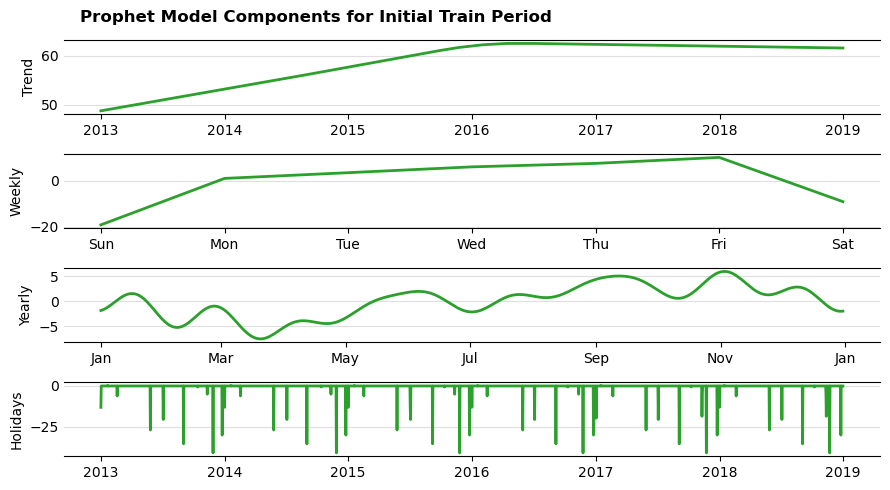

In [46]:
#retrain model with best rmse on initial train period
prophet_modeler_best_rmse = mod_info_p[np.argmin([i['metrics']['rmse'] for i in mod_info_p])]['modeler']
p_model = prophet_modeler_best_rmse.train(train_period = init_train_period, interval_width = interval_width, 
                                          log = False, store_model = True, return_model = True)
future_df = p_model.make_future_dataframe(periods = 0)
future_df = future_df.merge(df[['ds','snow_avg','snow_avg_2']], how = 'left', on = 'ds')
fcst = p_model.predict(future_df)
#plot prophet components
fig, axes = plt.subplots(4,1,figsize = (9,5))
components = {'trend':'Trend','weekly':'Weekly','yearly':'Yearly','holidays':'Holidays',
              'extra_regressors_additive':'Non-Holiday Exogenous\nPredictors (Additive)'}
axes[0].plot(fcst['ds'], fcst['trend'], color = 'C2', linewidth = 2)
axes[1].plot(np.arange(7), fcst['weekly'].tolist()[5:12], color = 'C2',linewidth = 2)
axes[1].set_xticks(np.arange(7),[calendar.day_name[i][:3] for i in [6,0,1,2,3,4,5]])
axes[2].plot(fcst['ds'].loc[:364], fcst['yearly'].tolist()[:365], color = 'C2',linewidth = 2)
axes[2].set_xticks(axes[2].get_xticks(),
                   [calendar.month_abbr[int(i.get_text().split('-')[1])] for i in axes[2].get_xticklabels()])
axes[3].plot(fcst['ds'], fcst['holidays'], color = 'C2',linewidth = 2)
rmv_spines = ['right','left']
for c,ax in zip(components,axes):
    for s in rmv_spines:
        ax.spines[s].set_visible(False)
    ax.set_axisbelow(True)
    ax.grid(axis = 'y', alpha = 0.4)
    ax.tick_params(axis = 'y', length = 0)
    ax.set_ylabel(components[c])
fig.suptitle('Prophet Model Components for Initial Train Period', weight = 'bold', x = 0.095, y = 0.97, ha = 'left')
fig.tight_layout()

We can also see the model's coefficients for `snow_avg` and `snow_avg_2`, which are 9.16 and -1.13, respectively. Similar to the SARIMAX model we examined that used a second-order polynomial transformation of the natural log of the snow volume, the squared variable coefficient is negative and the non-squared variable's coefficient is positive.

In [47]:
#prophet model coefficients
display(regressor_coefficients(p_model)[['regressor','coef_lower','coef','coef_upper']])

,regressor,coef_lower,coef,coef_upper
0,snow_avg,9.164326,9.164326,9.164326
1,snow_avg_2,-1.126854,-1.126854,-1.126854


### Comparing Model Forecast Performance

The visualization generated in the cell below enables us to compare the performance of the various Prophet models with each other, as well as with the SARIMAX models. 

Overall, the Prophet models achieved better RMSE and MAE scores than the SARIMAX models.

Similar to SARIMAX, Prophet achieved the best RMSE and MAE when using Snow Avg$^2$ and holidays as predictors, and both of these metrics were slightly better than those of the corresponding SARIMAX model. The Prophet model with these predictors achieved a slightly better RMSE of 11.69 and an MAE of 8.79, compared to 11.82 and 8.92 for the SARIMAX model. Similar to the results of the SARIMAX models, the Prophet models that incorporated holidays outperformed those that did not. In fact, we see here that the Prophet model that uses only holidays and no snow predictors performs ranked second in terms of best RMSE, and its performance is very similar to the top-ranked model.

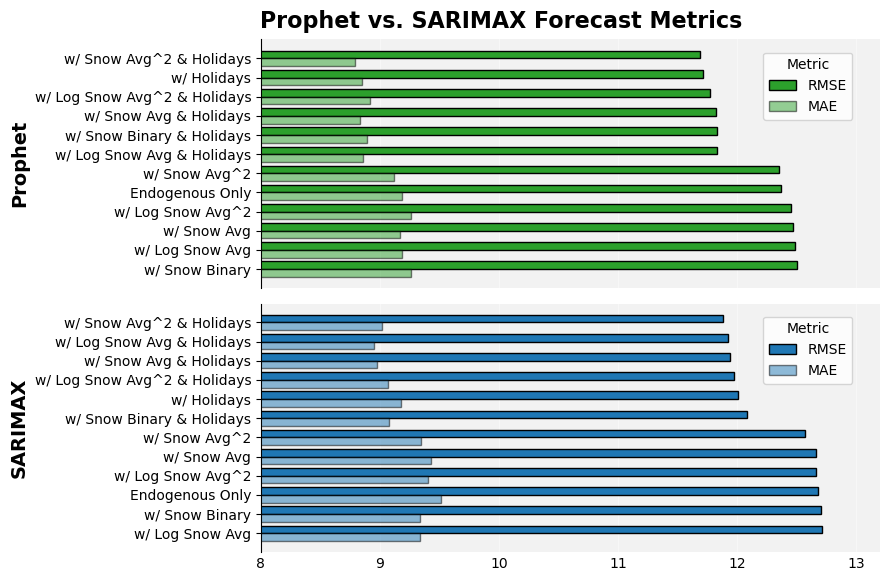

In [48]:
#plot forecast metrics for Prophet and SARIMAX
plot_df = pd.concat((prophet_results_df,sarimax_results_df))
plot_df['preds'] = plot_df['title'].apply(lambda x: re.sub(r'SARIMAX Forecast \(|Prophet Forecast \(|\)','',x))
plot_df['Includes Holidays'] = plot_df['title'].str.contains('Holidays')
plot_df['Modeling Approach'] = plot_df['title'].str.split().str.get(0)
mod_approaches = ['Prophet','SARIMAX']
rmv_spines = ['top','right','bottom']
colors = ['C2','C0']
fig,axes = plt.subplots(2,1,figsize = (9,6), sharex = True)
bh = 0.4
for ma,ax,c in zip(mod_approaches, axes, colors):
    d = plot_df[plot_df['Modeling Approach']==ma].sort_values('RMSE', ascending = False)
    ypos = np.arange(len(d['title']))
    ax.barh(y = ypos+bh/2, width = d['RMSE'], height = bh, color = c, label = 'RMSE', edgecolor = 'black')
    ax.barh(y = ypos-bh/2, width = d['MAE'], height = bh, color = c, alpha = 0.5, label = 'MAE', edgecolor = 'black')
    ax.set_yticks(ypos, d['preds'])
    ax.set_ylabel(ma, weight = 'bold', size = 14)
    ax.set_xlim(8,13.2)
    ax.set_axisbelow(True)
    ax.grid(axis = 'x', alpha = 0.4)
    ax.tick_params(axis = 'x', length = 0)
    for s in rmv_spines:
        ax.spines[s].set_visible(False)
    ax.set_facecolor((0.95,0.95,0.95))
    ax.set_axisbelow(True)
    ax.grid(axis = 'x', color = 'white')
    ax.legend(title = 'Metric', bbox_to_anchor = (0.8,0.65))
fig.suptitle('Prophet vs. SARIMAX Forecast Metrics', weight = 'bold', ha = 'left', x = 0.295, y = 0.96, size = 16)
fig.tight_layout()   

We can also view the differences in performance between the models in the two dimensions of RMSE and MAE using scatterplots. The chart on the left distinguishes between SARIMAX and Prophet using different colors, and between models the use holidays and those that do not with different markers. Viewed in this way, it is easy to see the Prophet models' tendency to outperform the SARIMAX models. We can also see that incorporating holidays has an even larger impact on model performance than whether Prophet or SARIMAX is used. 

In fact, if we were to create two clusters of models based on performance, it would make more sense to do so based on the inclusion of holidays rather than the modeling framework. This is illustrated using k-means clustering, shown in the chart on the right. The clusters correspond to whether the models include holidays or not, rather than whether the framework is Prophet or SARIMAX. Note that when k-means is applied here, we give MAE and RMSE equal weight by transforming both metrics to the same scale, although the results are the same even without applying this scaling.

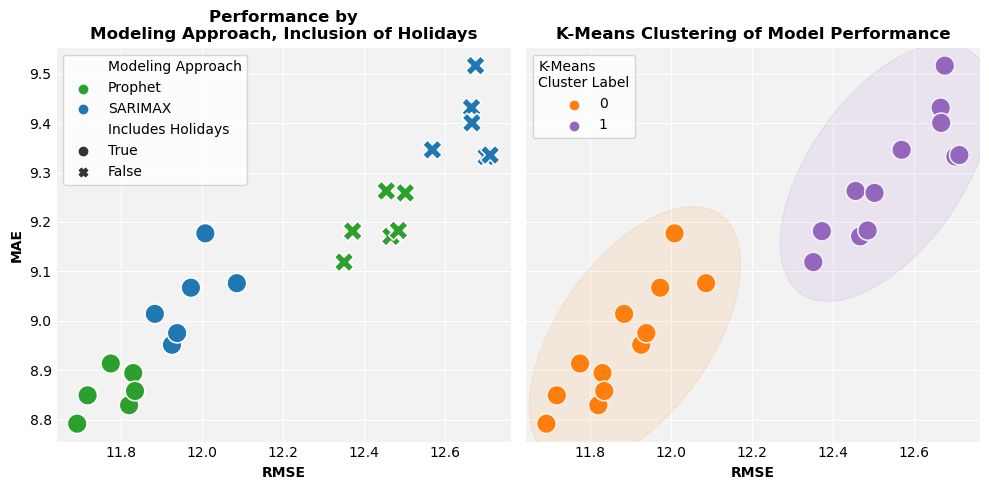

In [49]:
#model performance scatterplot
fig,axes = plt.subplots(1,2,figsize = (10,5), sharey = True, sharex = True)
sns.scatterplot(x = 'RMSE', y = 'MAE', hue = 'Modeling Approach', 
                style = 'Includes Holidays', data = plot_df, 
                ax = axes[0], s = 200, style_order = [True,False], palette = ['C2','C0'])
axes[0].set_xlabel('RMSE', weight = 'bold')
axes[0].set_ylabel('MAE', weight = 'bold')
axes[0].set_title('Performance by\nModeling Approach, Inclusion of Holidays', weight = 'bold')
axes[0].set_facecolor((0.95,0.95,0.95))
axes[0].set_axisbelow(True)
axes[0].grid(color = 'white')
axes[0].legend(loc = 'upper left')
axes[0].tick_params(axis = 'both', length = 0)
rmv_spines = ['top','right','bottom','left']
for s in rmv_spines:
    axes[0].spines[s].set_visible(False)
#apply K-means clustering and plot
cluster_data = plot_df[['MAE','RMSE']].copy()
scaler = MinMaxScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)
kmeans = KMeans(n_clusters = 2, n_init = 'auto', random_state = 123)
labels = kmeans.fit_predict(cluster_data_scaled)
plot_df['cluster_labels'] = labels
sns.scatterplot(x = 'RMSE', y = 'MAE', hue = 'cluster_labels', data = plot_df, 
                ax = axes[1], s = 200, style_order = [True,False], palette = ['C1','C4'])
axes[1].set_xlabel('RMSE', weight = 'bold')
axes[1].set_ylabel('MAE', weight = 'bold')
axes[1].set_title('K-Means Clustering of Model Performance', 
                  weight = 'bold')
axes[1].set_facecolor((0.95,0.95,0.95))
axes[1].set_axisbelow(True)
axes[1].grid(color = 'white')
axes[1].legend(title = 'K-Means\nCluster Label',loc = 'upper left')
axes[1].tick_params(axis = 'both', length = 0)
rmv_spines = ['top','right','bottom','left']
for s in rmv_spines:
    axes[1].spines[s].set_visible(False)
axes[1].add_artist(Ellipse(xy = (11.91, 8.97), width = .65, height = .35, 
                           angle = 45, alpha = 0.1, color = 'C1'))
axes[1].add_artist(Ellipse(xy = (12.53, 9.3), width = .65, height = .35, 
                           angle = 45, alpha = 0.1, color = 'C4'))
fig.tight_layout()

#### Visualizing the Best-Scoring Models from Prophet and SARIMAX

Finally, we can also look at the models' predictions throughout the forecast period and check how they compare to the actual values. This is done below for the Prophet and SARIMAX models that achieved the lowest RMSE scores. We can see that their predictions track reasonably well with the actual data, particularly when it comes to capturing the weekly seasonality. However, there are clearly a number of days with many crashes where both models underestimate, as well as a number of days with few crashes where both models overestimate. The models appear to have underestimated numerous peaks in crashes around late January-early February, as well as around the late August-early October timeframe. They also had some trouble tracking erratic patterns around the Thanksgiving and Christmas holidays in late November and late December, respectively. This would be important to keep in mind if forecasting with either of these models, and it would be worth exploring ways to improve upon this, such as by experimenting with additional predictors to see whether they can help account for these discrepancies.

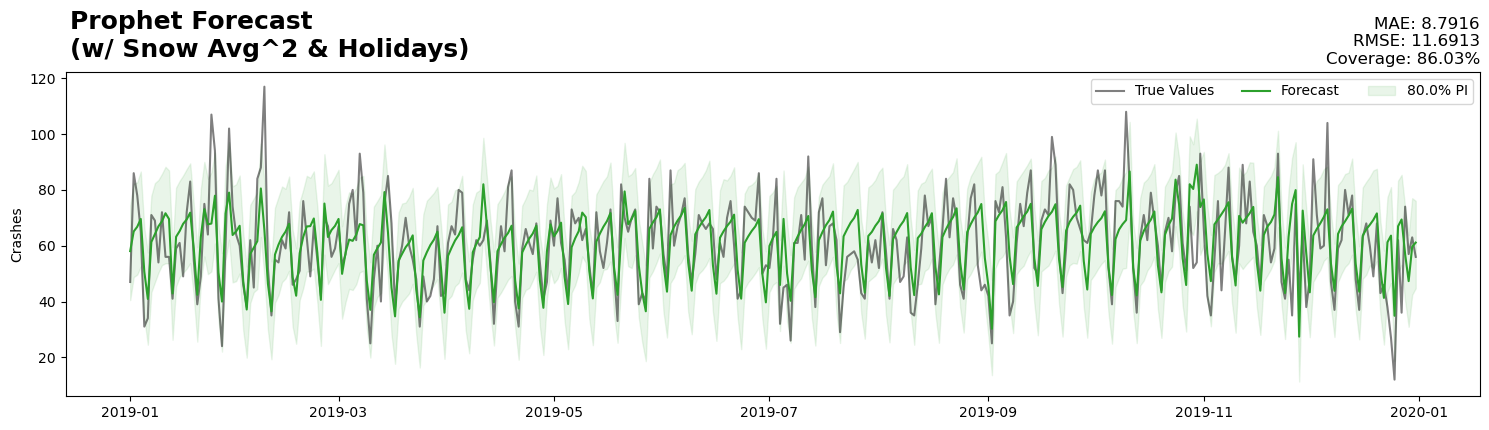

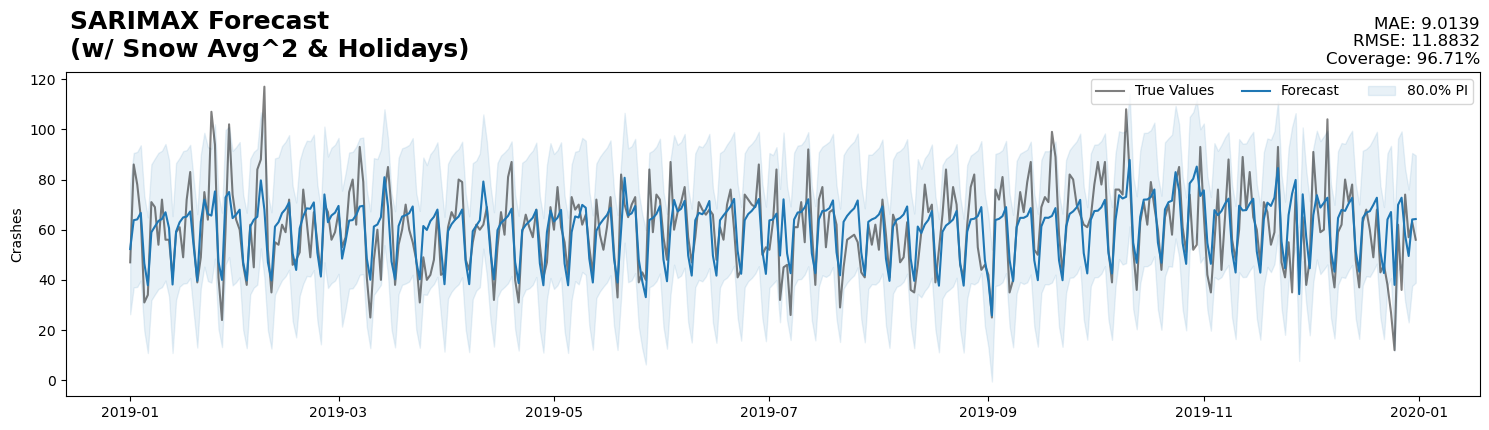

In [50]:
#prophet
best_rmse_prophet = mod_info_p[np.argsort([i['metrics']['rmse'] for i in mod_info_p])[0]]
best_rmse_prophet['modeler'].expanding_window_forecast(init_train_period = init_train_period, 
                                       step_size = step_size, 
                                       interval_width = interval_width,
                                       plot_title = best_rmse_prophet['title'],
                                       plot = True, return_metrics = False)
#sarimax
best_rmse_sarimax = mod_info_s[np.argsort([i['metrics']['rmse'] for i in mod_info_s])[0]]
best_rmse_sarimax['modeler'].expanding_window_forecast(init_train_period = init_train_period, 
                                       step_size = step_size, 
                                       interval_width = interval_width,
                                       order = best_rmse_sarimax['best_order'], 
                                       seasonal_order = best_rmse_sarimax['best_seasonal_order'], 
                                       plot_title = best_rmse_sarimax['title'],
                                       plot = True, return_metrics = False)

### Summary and Conclusion

We have built several models capable of forecasting the number of car crashes in Denver with average daily errors of fewer than nine crashes in 2019. In the process, we found that including holidays yielded a marked improvement in model performance. The Prophet models also tended to do better than the SARIMAX models. Adding snow variables showed some potential for improving model performance in certain cases, although gains were not dramatic. More fundamentally, because the models that incorporated snow utilized actual historical snow data rather than snow forecasts, the metrics of these models are likely too optimistic, so these snow variables do not seem ideal for use in a real-world application. Using the Prophet model with only holidays as an exogenous predictor might be more practical, while continuing to explore other variables that might improve its performance. These variabls could include dates that fall <i>near</i> the holidays, or other special dates relevant to Denver but not included in the current list of holidays, such as local sporting events or school closures.